# One Pixel Attack Tutorial
## Part 1 - Cifar10

### Dan Kondratyuk
### September 15, 2019

![](images/pred2.png "All it takes is one pixel")

This notebook will demonstrate the one pixel attack with a few different convolutional neural network models. By using differential evolution, we find a special pixel that can modify a target image such that the network misclassifies the image (which it previously correctly classified).

In theory, we want models that don't get fooled by such tiny changes. Especially in images, it is undesirable to have a small alteration in the input result in a drastic change in the output. However, even the most accurate neural networks are susceptible to this type of attack.

To read more about it, see [the original paper](https://arxiv.org/abs/1710.08864), or the authors' [official repo](https://github.com/Carina02/One-Pixel-Attack).

Let's get started.

## Imports

Ensure that you have `numpy`, `pandas`, `scipy`, `matplotlib`, `tensorflow-gpu`, and `keras` installed.

Alternatively, you may [run this notebook in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7). Note: colab allows you to run this notebook on GPU, free of charge. Simply select "GPU" in the Accelerator drop-down in Notebook Settings (either through the Edit menu or the command palette at cmd/ctrl-shift-P).

In [4]:
# If running in Google Colab, import files
try:
    import google.colab
    in_colab = True
except:
    in_colab = False

if in_colab:
    !git clone https://github.com/Hyperparticle/one-pixel-attack-keras.git
    !mv -v one-pixel-attack-keras/* .
    !rm -rf one-pixel-attack-keras



Cloning into 'one-pixel-attack-keras'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 356 (delta 3), reused 2 (delta 0), pack-reused 346
Receiving objects: 100% (356/356), 44.57 MiB | 19.47 MiB/s, done.
Resolving deltas: 100% (204/204), done.
renamed 'one-pixel-attack-keras/1_one-pixel-attack-cifar10.ipynb' -> './1_one-pixel-attack-cifar10.ipynb'
renamed 'one-pixel-attack-keras/2_one-pixel-attack-imagenet.ipynb' -> './2_one-pixel-attack-imagenet.ipynb'
renamed 'one-pixel-attack-keras/attack.py' -> './attack.py'
renamed 'one-pixel-attack-keras/CONTRIBUTING.md' -> './CONTRIBUTING.md'
mv: cannot move 'one-pixel-attack-keras/data' to './data': Directory not empty
renamed 'one-pixel-attack-keras/differential_evolution.py' -> './differential_evolution.py'
renamed 'one-pixel-attack-keras/helper.py' -> './helper.py'
mv: cannot move 'one-pixel-attack-keras/images' to './images': Directory not

In [5]:
# Python Libraries
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib
from keras.datasets import cifar10
from keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD

In [6]:
from networks.lenet import LeNet
from networks.pure_cnn import PureCnn

In [16]:
# Custom Networks


from networks.network_in_network import NetworkInNetwork
from networks.resnet import ResNet
from networks.densenet import DenseNet
from networks.wide_resnet import WideResNet
from networks.capsnet import CapsNet

# Helper functions
from differential_evolution import differential_evolution
import helper

matplotlib.style.use('ggplot')
np.random.seed(100)

## Load Dataset

For this attack, we will use the [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) packaged by Keras. The task of the dataset is to correctly classify a 32x32 pixel image in 1 of 10 categories (e.g., bird, deer, truck).

The code below will load the Cifar10 dataset. Keras will need to download the dataset if it is not cached locally already.

In [17]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [18]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

We can access and display any image in the dataset by its index. For instance, here is a horse.

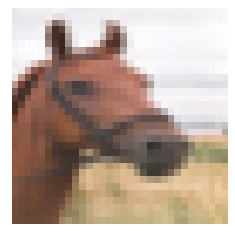

In [19]:
image_id = 99 # Image index in the test set
helper.plot_image(x_test[image_id])

## Image Perturbation

To begin, we need a function to modify one or more pixels in an image. 

We can define the perturbation of a pixel as a 5-tuple 

$$\textbf{x} = (x, y, r, g, b)$$

where $x, y$ are the coordinates of the pixel from 0 to 31, and $r,g,b$ are the red, green, and blue values from 0 to 255. Then multiple perturbations can simply be a concatenation of these tuples:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

We could instead use an array of tuples, but the optimization algorithm we will use requires it to be a flat 1-d vector.

Then the function to perturb an image can take as an input the image and $X$, and output a copy of the image with each pixel at $x_i, y_i$ modified to have the color $r_i, g_i, b_i$. To speed up computation, we will batch together an array of $X$ perturbations, denoted $X_S$.

In [20]:
def perturb_image(xs, img):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])
    
    # Copy the image n == len(xs) times so that we can 
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(img, tile)
    
    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)
    
    for x,img in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            img[x_pos, y_pos] = rgb
    
    return imgs

Now we can modify the pixels of any image we want.

Let's modify our horse image by making pixel (16,16) yellow.

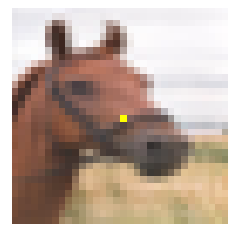

In [21]:
image_id = 99 # Image index in the test set
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, x_test[image_id])[0]

helper.plot_image(image_perturbed)

## Load Models

To demonstrate the attack, we need some neural network models trained on the Cifar10 dataset. We will now load some pretrained models, which can be found in the `networks/models` directory.

It is recommended to use Keras with a GPU enabled. If you're [running in Google Colab](https://colab.research.google.com/drive/1Zq1kGP9C7i-70-SXyuEEaqYngtyQZMn7), you can enable a GPU instance by selecting `Runtime > Change runtime type > Hardware accelerator > GPU` (you will need to re-run all cells). The code below can be used to check (if using TensorFlow).

In [28]:
# Should output /device:GPU:0
#import tensorflow.keras.backend as K
#K.tensorflow_backend._get_available_gpus()
#K._get_available_gpus()
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

There are two models included in this repository, `lenet` and `resnet` which will be loaded from disk automatically.

Optionally, you may [download the larger, more accurate models](https://www.dropbox.com/sh/dvatkpjl0sn79kn/AAC9L4puJ_sdFUkDZfr5SFkLa?dl=0) (e.g., Capsule Network, DenseNet, etc.). Make sure to copy the models into the `networks/models/` directory. Then uncomment the lines below and run the cell to load the models of your choosing.

In [29]:
lenet = LeNet()
resnet = ResNet()

models = [lenet, resnet]

## Uncomment below to load more models to play with. Make sure the model files exist by training or downloading them.

# lenet = LeNet()
# pure_cnn = PureCnn()
# net_in_net = NetworkInNetwork()
# resnet = ResNet()
# densenet = DenseNet()
# wide_resnet = WideResNet()
# capsnet = CapsNet()

# models = [lenet, pure_cnn, net_in_net, resnet, densenet, wide_resnet, capsnet]

Successfully loaded lenet
Successfully loaded resnet


Note that there are even more networks available in the `networks` directory, but must be trained before loading them here.

### Calculate Model Accuracies

After loading the models, we would like to evaluate all test images with each model to ensure that we only attack the images which have been classified correctly. The code below will also display the accuracy and number of parameters of each model.

In [30]:
network_stats, correct_imgs = helper.evaluate_models(models, x_test, y_test)
correct_imgs = pd.DataFrame(correct_imgs, columns=['name', 'img', 'label', 'confidence', 'pred'])
network_stats = pd.DataFrame(network_stats, columns=['name', 'accuracy', 'param_count'])

network_stats

Evaluating lenet
Evaluating resnet


name  accuracy  param_count
0   lenet    0.7488        62006
1  resnet    0.9231       470218

### Prediction Function

For the black-box attack, all we should care about is the inputs to the model (the images), and the outputs of the model (the prediction probabilities). No special information about the model is required; we could even swap it with a model that is not a neural network.

Define a function that runs several perturbed images on a given model and returns the model's confidence (probability output) in the target class, one confidence value per image. If the target class is the correct class, this will be the function that we want to minimize so that the model will be most confident in another class (which is incorrect). Otherwise, the target is an incorrect class and we will want to maximize it.

In [31]:
def predict_classes(xs, img, target_class, model, minimize=True):
    # Perturb the image with the given pixel(s) x and get the prediction of the model
    imgs_perturbed = perturb_image(xs, img)
    predictions = model.predict(imgs_perturbed)[:,target_class]
    # This function should always be minimized, so return its complement if needed
    return predictions if minimize else 1 - predictions

Below we can modify a pixel in an image and see how the confidence of the model changes. In almost all cases, the confidence will not change. However, for very special cases it will change drastically.

Confidence in true class bird is 0.00018887481
Prior confidence was 0.70661867


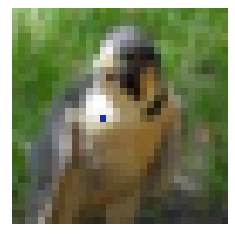

In [33]:
image_id = 384
pixel = np.array([16, 13,  25, 48, 156])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
confidence = predict_classes(pixel, x_test[image_id], true_class, model)[0]

print('Confidence in true class', class_names[true_class], 'is', confidence)
print('Prior confidence was', prior_confidence)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

## The Attack

Here we will demonstrate two variants of the one pixel attack: untargeted and targeted.

### Targeted vs. Untargeted Attacks

The objective of an untargeted attack is to cause a model to misclassify an image. This means we want to perturb an image as to minimize the confidence probability of the correct classification category and maximize the sum of the probabilities of all other categories.

The objective of a targeted attack is to cause a model to classify an image as a given  target class. We want to perturb an image as to maximize the probability of a class of our own choosing.

### Success Criterion

Define a function so that whenever a given perturbation is sufficient to fool a model, it returns `True`. This will be called the success criterion. The `targeted_attack` boolean flag will indicate whether success means maximization of the target class or minimization of the correct (target) class.

In [34]:
def attack_success(x, img, target_class, model, targeted_attack=False, verbose=False):
    # Perturb the image with the given pixel(s) and get the prediction of the model
    attack_image = perturb_image(x, img)

    confidence = model.predict(attack_image)[0]
    predicted_class = np.argmax(confidence)
    
    # If the prediction is what we want (misclassification or 
    # targeted classification), return True
    if verbose:
        print('Confidence:', confidence[target_class])
    if ((targeted_attack and predicted_class == target_class) or
        (not targeted_attack and predicted_class != target_class)):
        return True
    # NOTE: return None otherwise (not False), due to how Scipy handles its callback function

Here we demonstrate the usage of the success criterion function. It's nearly identical to `predict_class()` as before, but also decides the success of the attack. For purposes of demonstration we assume an untargeted attack.

Confidence: 0.07460098
Prior confidence 0.5005425
Attack success: True


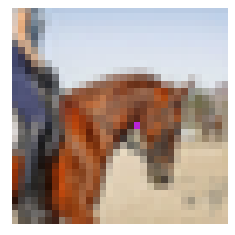

In [36]:
image_id = 541
pixel = np.array([17, 18, 185, 36, 215])
model = resnet

true_class = y_test[image_id, 0]
prior_confidence = model.predict_one(x_test[image_id])[true_class]
success = attack_success(pixel, x_test[image_id], true_class, model, verbose=True)

print('Prior confidence', prior_confidence)
print('Attack success:', success == True)
helper.plot_image(perturb_image(pixel, x_test[image_id])[0])

### Attack Function

Finally, we arrive at the attack itself: how do we find the pixels that will result in a successful attack? First, formulate it as an optimization problem: in an untargeted attack, minimize the confidence of the correct class, and in a targeted attack, maximize the confidence of a target class. This is precisely our `predict_class` function.

When performing black-box optimizations such as the one pixel attack, it can be very difficult to find an efficient gradient-based optimization that will work for the problem. It would be nice to use an optimization algorithm that can find good solutions without relying on the smoothness of the function. In our case, we have discrete integer positions ranging from 0 to 31 and color intensities from 0 to 255, so the function is expected to be jagged.

For that, we use an algorithm called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). Here's an example of differential evolution optimizing the [Ackley function](https://en.wikipedia.org/wiki/Ackley_function) (if you're using Google Colab, run the code cell below):

<br>

![Ackley GIF](https://github.com/hyperparticle/one-pixel-attack-keras/blob/master/images/Ackley.gif?raw=1)

<br>

Differential evolution is a type of evolutionary algorithm where a population of candidate solutions generate offspring which compete with the rest of the population each generation according to their fitness. Each candidate solution is represented by a vector of real numbers which are the inputs to the function we would like to minimize. The lower the output of this function, the better the fitness. The algorithm works by initializing a (usually random) population of vectors, generating new offspring vectors by combining (mutating) individuals in the population, and replacing worse-performing individuals with better candidates.

In the context of the one pixel attack, our input will be a flat vector of pixel values:

$$X = (x_1, y_1, r_1, g_1, b_1, x_2, y_2, r_2, g_2, b_2, ...)$$

These will be encoded as floating-point values, but will be floored back into integers to calculate image perturbations. First we generate a random population of $n$ perturbations

$$\textbf{P} = (X_1, X_2, \dots, X_n)$$

Then, on each iteration we calculate $n$ new mutant children using the formula

$$X_i = X_{r1} + F (X_{r2} - X_{r3})$$

such that

$$r1 \neq r2 \neq r3$$

where $r1,r2,r3$ are random indices into our population $\textbf{P}$, and $F = 0.5$ is a mutation parameter. Basically, we pick 3 random individuals from the previous generation and recombine them to make a new candidate solution. If this candidate $X_i$ gives a lower minimum at position $i$ (i.e., the attack is closer to success), replace the old $X_i$ with this new one. This process repeats for several iterations until our stopping criterion, `attack_success`, which is when we find an image that successfully completes the attack.

<br>

See [this excellent tutorial post](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/) on how differential evolution works in greater detail. 

We will use a [slight modification](differential_evolution.py) of [Scipy's implementation of differential evolution](https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html) to utilize GPU parallelism by batching predictions together.

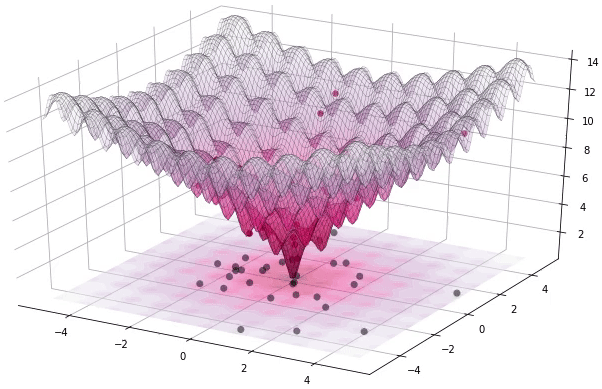

In [41]:
# Run this cell if you are using Google Colab to see the Ackley GIF
if in_colab:
    from IPython.display import Image
    with open('images/Ackley.gif','rb') as file:
        display(Image(file.read()))

In [42]:
def attack(img_id, model, target=None, pixel_count=1, 
           maxiter=75, popsize=400, verbose=False):
    # Change the target class based on whether this is a targeted attack or not
    targeted_attack = target is not None
    target_class = target if targeted_attack else y_test[img_id, 0]
    
    # Define bounds for a flat vector of x,y,r,g,b values
    # For more pixels, repeat this layout
    bounds = [(0,32), (0,32), (0,256), (0,256), (0,256)] * pixel_count
    
    # Population multiplier, in terms of the size of the perturbation vector x
    popmul = max(1, popsize // len(bounds))
    
    # Format the predict/callback functions for the differential evolution algorithm
    def predict_fn(xs):
        return predict_classes(xs, x_test[img_id], target_class, 
                               model, target is None)
    
    def callback_fn(x, convergence):
        return attack_success(x, x_test[img_id], target_class, 
                              model, targeted_attack, verbose)
    
    # Call Scipy's Implementation of Differential Evolution
    attack_result = differential_evolution(
        predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False)

    # Calculate some useful statistics to return from this function
    attack_image = perturb_image(attack_result.x, x_test[img_id])[0]
    prior_probs = model.predict_one(x_test[img_id])
    predicted_probs = model.predict_one(attack_image)
    predicted_class = np.argmax(predicted_probs)
    actual_class = y_test[img_id, 0]
    success = predicted_class != actual_class
    cdiff = prior_probs[actual_class] - predicted_probs[actual_class]

    # Show the best attempt at a solution (successful or not)
    helper.plot_image(attack_image, actual_class, class_names, predicted_class)

    return [model.name, pixel_count, img_id, actual_class, predicted_class, success, cdiff, prior_probs, predicted_probs, attack_result.x]

#### Untargeted Attack

Let's look at one iteration of the untargeted attack. Here we will demonstrate a successful attack an image of a frog with the `resnet` model. We should see the confidence in the true class drop after several iterations.

Try to see if you can successfully attack other images/models. The more pixels we are allowed to modify, the more likely it is we are to find a solution for any given image.

Confidence: 0.9822535
Confidence: 0.75205994
Confidence: 0.75205994
Confidence: 0.7333128
Confidence: 0.7333128
Confidence: 0.7333128
Confidence: 0.3855776


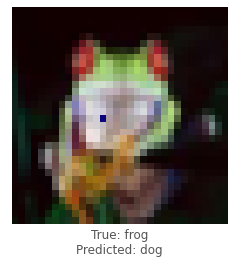

In [43]:
image_id = 102
pixels = 1 # Number of pixels to attack
model = resnet

_ = attack(image_id, model, pixel_count=pixels, verbose=True)

#### Targeted Attack

In the targeted attack, we can choose which class we want a model to classify an image as. The task is much harder for the targeted attack, as we constrain the misclassification to a given class rather than any class that's not the correct one. We should see the confidence in the target class rise after several iterations.

Below we try to cause the `lenet` to classify an image of a `ship` as an `automobile`. Try to change the parameters and see what happens.

Attacking with target automobile
Confidence: 0.027326964
Confidence: 0.027326964
Confidence: 0.027326964
Confidence: 0.029593209
Confidence: 0.029593209
Confidence: 0.029593209
Confidence: 0.042801965
Confidence: 0.042801965
Confidence: 0.042801965
Confidence: 0.042801965
Confidence: 0.042801965
Confidence: 0.07617832
Confidence: 0.07617832
Confidence: 0.15848312
Confidence: 0.15848312
Confidence: 0.15848312
Confidence: 0.15848312
Confidence: 0.15848312
Confidence: 0.15848312
Confidence: 0.15848312
Confidence: 0.15848312
Confidence: 0.20948072
Confidence: 0.20948072
Confidence: 0.20948072
Confidence: 0.20948072
Confidence: 0.20948072
Confidence: 0.2854001
Confidence: 0.2854001
Confidence: 0.2854001
Confidence: 0.2854001
Confidence: 0.2854001
Confidence: 0.2854001
Confidence: 0.2903382
Confidence: 0.33978742
Confidence: 0.48251554
Confidence: 0.48251554
Confidence: 0.48251554
Confidence: 0.49858543


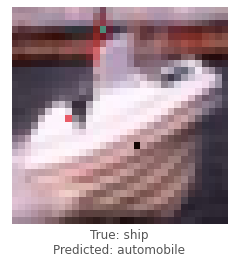

In [44]:
image_id = 108
target_class = 1 # Integer in range 0-9
pixels = 3
model = lenet

print('Attacking with target', class_names[target_class])
_ = attack(image_id, model, target_class, pixel_count=pixels, verbose=True)

### Collect Results

Armed with all the necessary tools to conduct a one pixel attack, the final step is to collect relevant statistics on the targeted and untargeted attack. The relevant data points are what percentage of images were we able to successfully attack for a given model, and how the number of pixels affect this percentage.

We will loop through every combination of all models, perturbations of 1,3,5 pixels, images, and target classes (for the targeted attack). This will take a lot of computational resources and time, so [skip to the statistics section](#Attack-Statistics) if that's not your idea of fun.

In [45]:
def attack_all(models, samples=500, pixels=(1,3,5), targeted=False, 
               maxiter=75, popsize=400, verbose=False):
    results = []
    for model in models:
        model_results = []
        valid_imgs = correct_imgs[correct_imgs.name == model.name].img
        img_samples = np.random.choice(valid_imgs, samples, replace=False)
        
        for pixel_count in pixels:
            for i, img_id in enumerate(img_samples):
                print('\n', model.name, '- image', img_id, '-', i+1, '/', len(img_samples))
                targets = [None] if not targeted else range(10)
                
                for target in targets:
                    if targeted:
                        print('Attacking with target', class_names[target])
                        if target == y_test[img_id, 0]:
                            continue
                    result = attack(img_id, model, target, pixel_count, 
                                    maxiter=maxiter, popsize=popsize, 
                                    verbose=verbose)
                    model_results.append(result)
                    
        results += model_results
        helper.checkpoint(results, targeted)
    return results


 lenet - image 2918 - 1 / 100


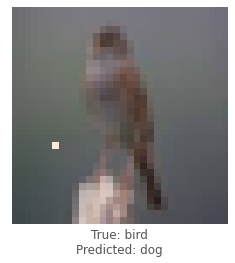


 lenet - image 3941 - 2 / 100


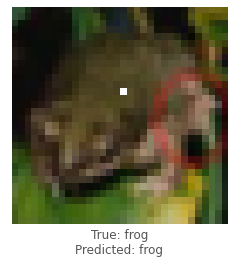


 lenet - image 1257 - 3 / 100


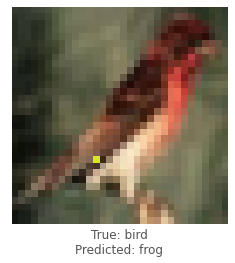


 lenet - image 5766 - 4 / 100


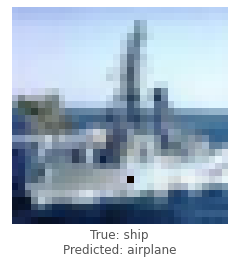


 lenet - image 1045 - 5 / 100


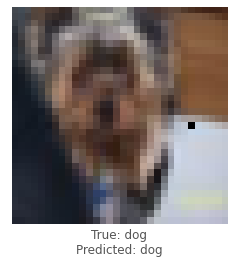


 lenet - image 2819 - 6 / 100


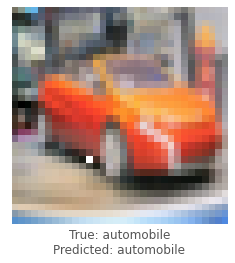


 lenet - image 2295 - 7 / 100


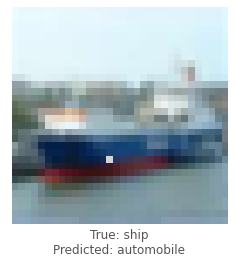


 lenet - image 7520 - 8 / 100


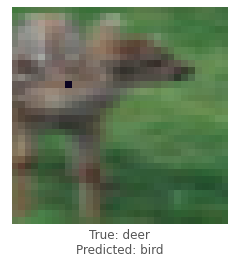


 lenet - image 4743 - 9 / 100


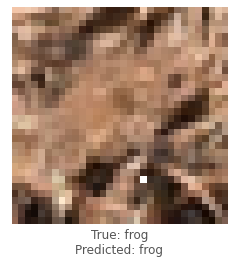


 lenet - image 7677 - 10 / 100


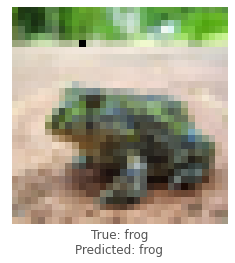


 lenet - image 9183 - 11 / 100


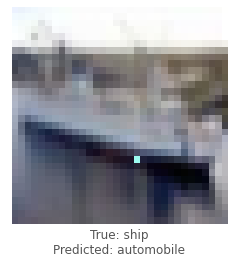


 lenet - image 3529 - 12 / 100


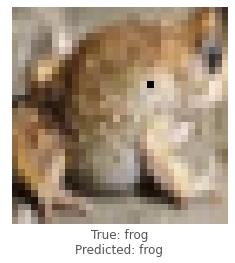


 lenet - image 5217 - 13 / 100


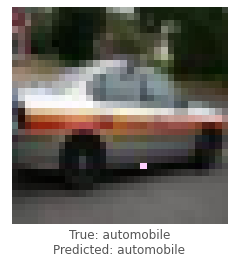


 lenet - image 4638 - 14 / 100


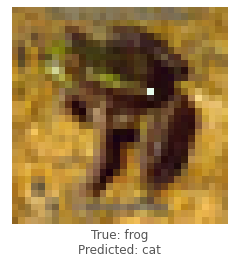


 lenet - image 6967 - 15 / 100


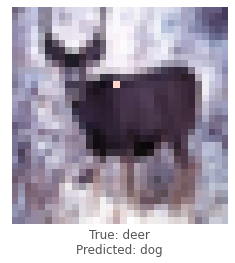


 lenet - image 9025 - 16 / 100


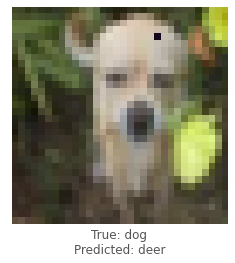


 lenet - image 6053 - 17 / 100


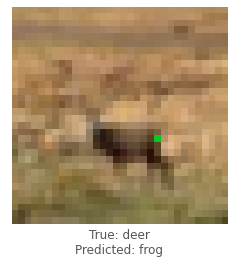


 lenet - image 4640 - 18 / 100


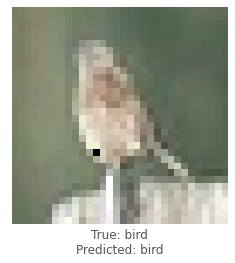


 lenet - image 976 - 19 / 100


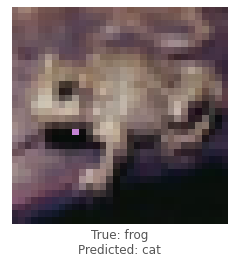


 lenet - image 9408 - 20 / 100


/content/differential_evolution.py:585: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


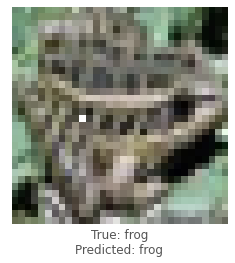


 lenet - image 3689 - 21 / 100


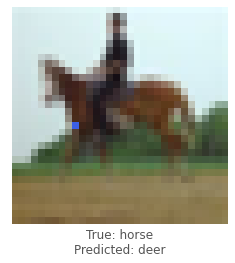


 lenet - image 6154 - 22 / 100


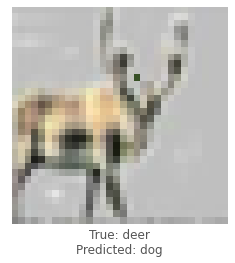


 lenet - image 9925 - 23 / 100


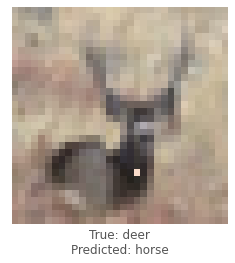


 lenet - image 3437 - 24 / 100


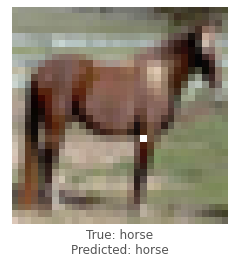


 lenet - image 197 - 25 / 100


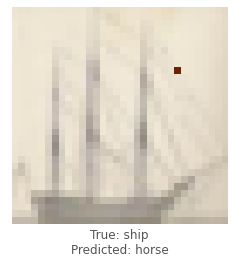


 lenet - image 6358 - 26 / 100


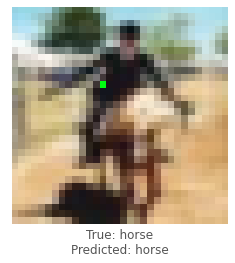


 lenet - image 2849 - 27 / 100


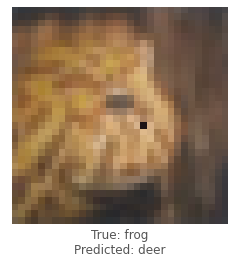


 lenet - image 3326 - 28 / 100


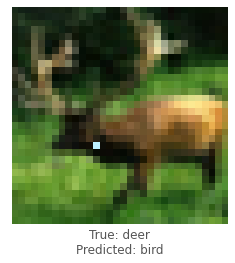


 lenet - image 7820 - 29 / 100


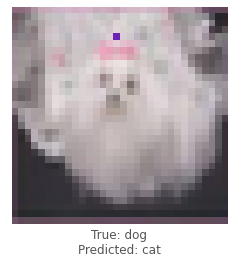


 lenet - image 7577 - 30 / 100


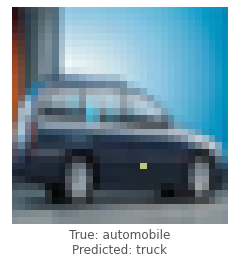


 lenet - image 3248 - 31 / 100


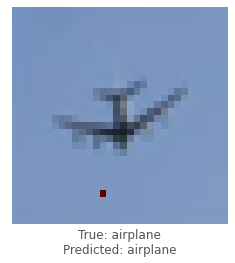


 lenet - image 1357 - 32 / 100


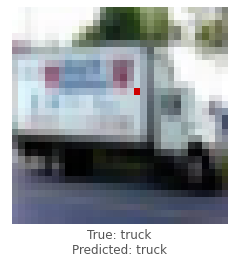


 lenet - image 455 - 33 / 100


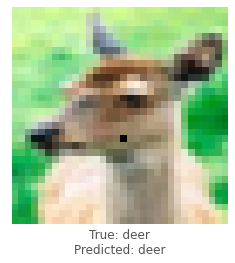


 lenet - image 1365 - 34 / 100


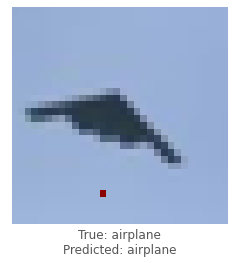


 lenet - image 6140 - 35 / 100


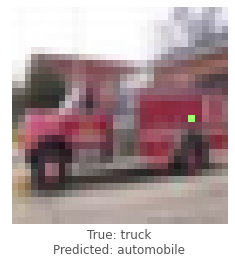


 lenet - image 4670 - 36 / 100


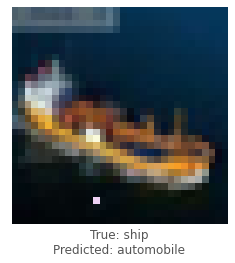


 lenet - image 8669 - 37 / 100


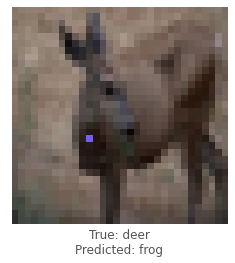


 lenet - image 2056 - 38 / 100


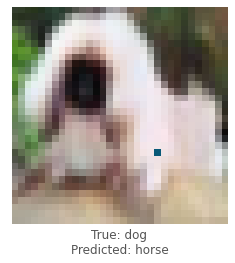


 lenet - image 7315 - 39 / 100


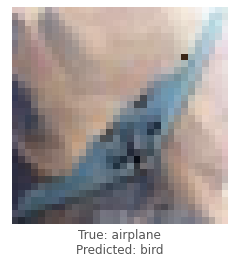


 lenet - image 1498 - 40 / 100


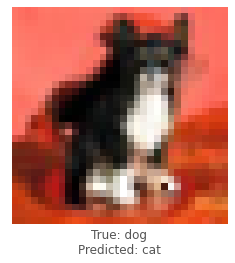


 lenet - image 7335 - 41 / 100


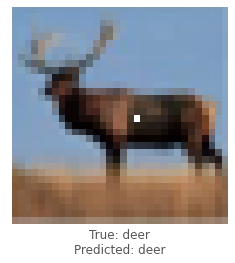


 lenet - image 1833 - 42 / 100


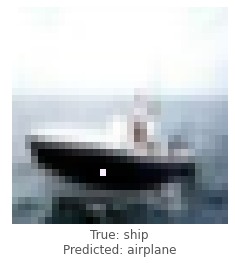


 lenet - image 3876 - 43 / 100


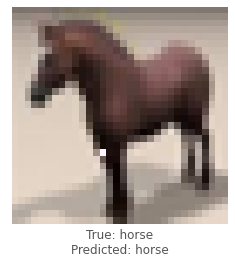


 lenet - image 8546 - 44 / 100


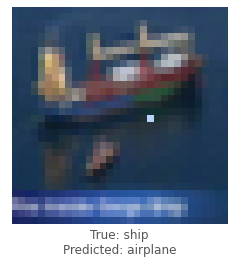


 lenet - image 2794 - 45 / 100


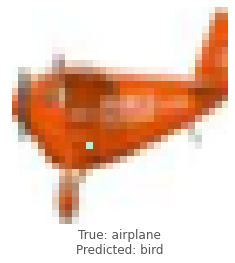


 lenet - image 1143 - 46 / 100


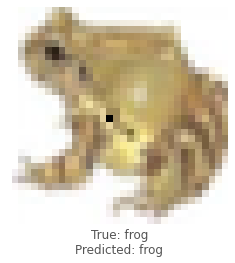


 lenet - image 7565 - 47 / 100


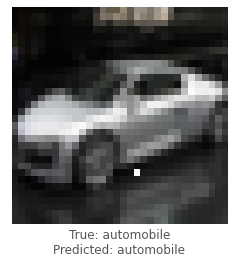


 lenet - image 4644 - 48 / 100


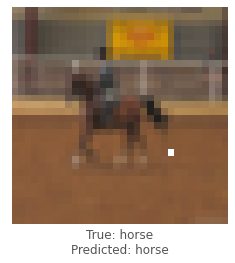


 lenet - image 8989 - 49 / 100


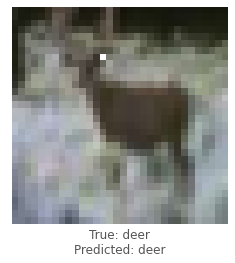


 lenet - image 8971 - 50 / 100


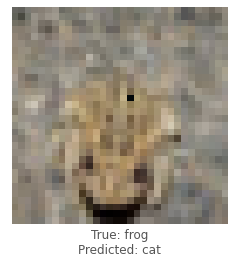


 lenet - image 1661 - 51 / 100


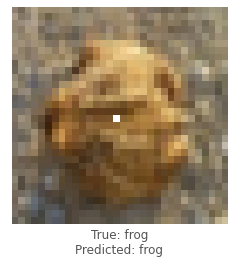


 lenet - image 344 - 52 / 100


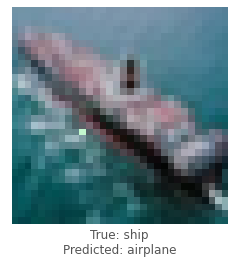


 lenet - image 8249 - 53 / 100


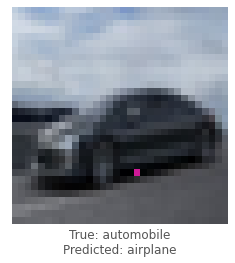


 lenet - image 6758 - 54 / 100


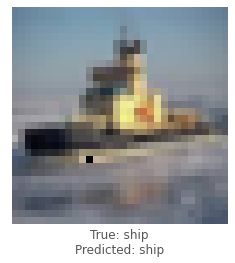


 lenet - image 5686 - 55 / 100


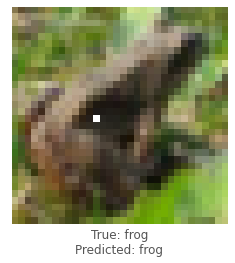


 lenet - image 9101 - 56 / 100


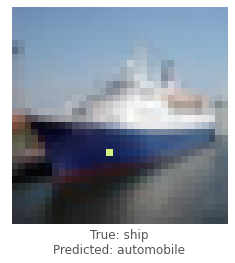


 lenet - image 2454 - 57 / 100


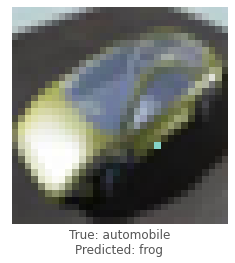


 lenet - image 9736 - 58 / 100


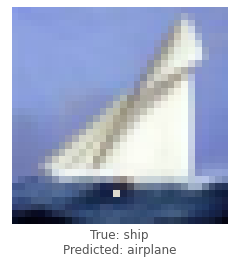


 lenet - image 506 - 59 / 100


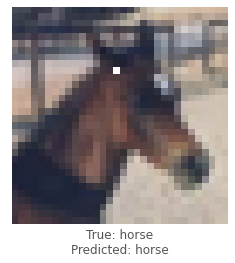


 lenet - image 4657 - 60 / 100


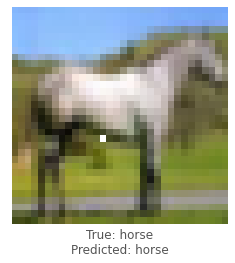


 lenet - image 7144 - 61 / 100


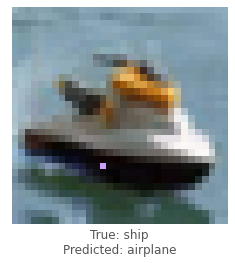


 lenet - image 7737 - 62 / 100


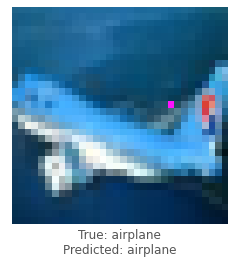


 lenet - image 9956 - 63 / 100


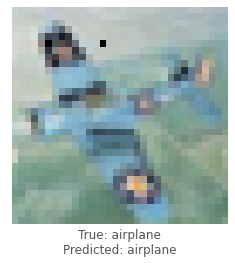


 lenet - image 9278 - 64 / 100


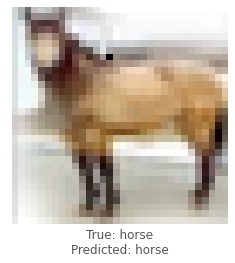


 lenet - image 1541 - 65 / 100


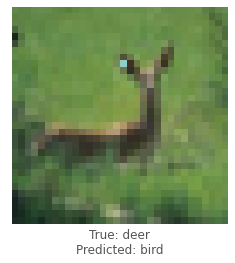


 lenet - image 4893 - 66 / 100


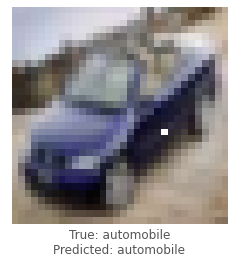


 lenet - image 6327 - 67 / 100


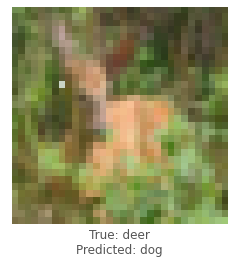


 lenet - image 3794 - 68 / 100


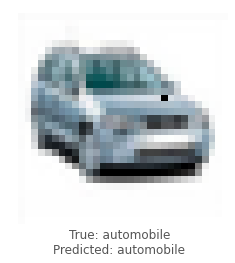


 lenet - image 7331 - 69 / 100


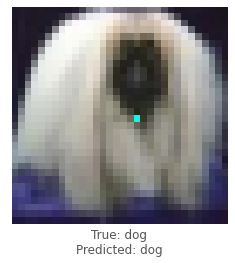


 lenet - image 7409 - 70 / 100


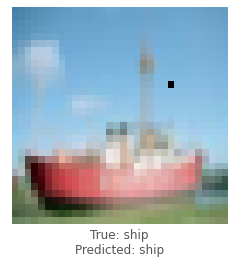


 lenet - image 7687 - 71 / 100


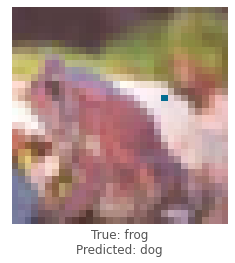


 lenet - image 6475 - 72 / 100


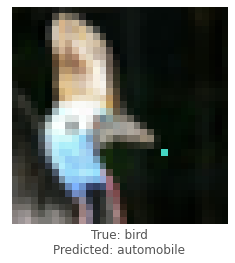


 lenet - image 5692 - 73 / 100


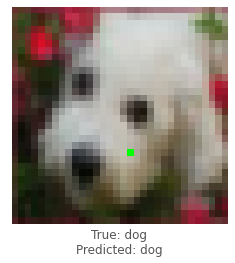


 lenet - image 656 - 74 / 100


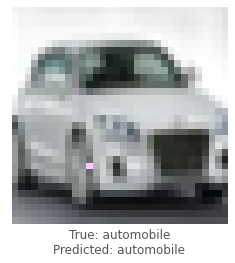


 lenet - image 7476 - 75 / 100


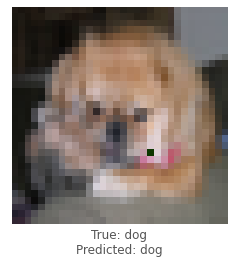


 lenet - image 3718 - 76 / 100


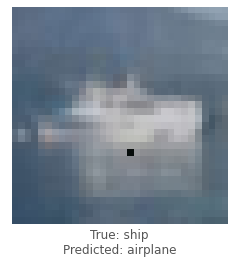


 lenet - image 890 - 77 / 100


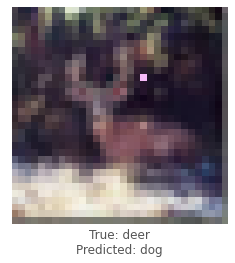


 lenet - image 3212 - 78 / 100


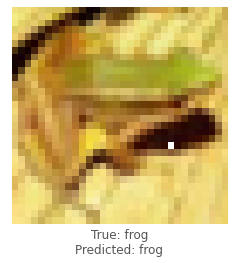


 lenet - image 9435 - 79 / 100


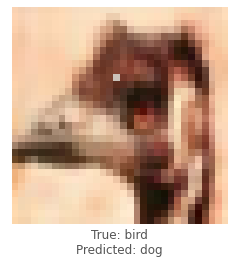


 lenet - image 6375 - 80 / 100


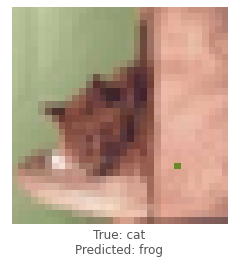


 lenet - image 2622 - 81 / 100


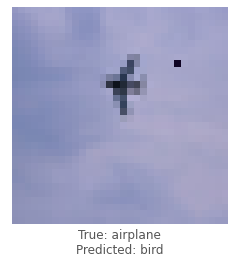


 lenet - image 9014 - 82 / 100


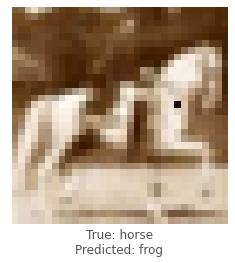


 lenet - image 6613 - 83 / 100


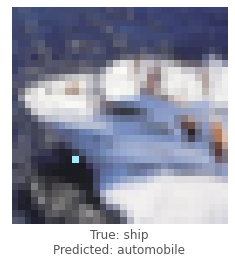


 lenet - image 7208 - 84 / 100


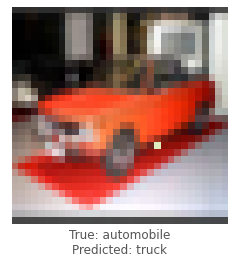


 lenet - image 4202 - 85 / 100


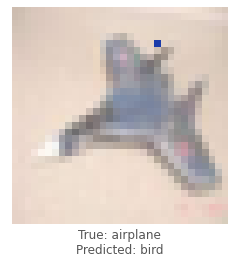


 lenet - image 9488 - 86 / 100


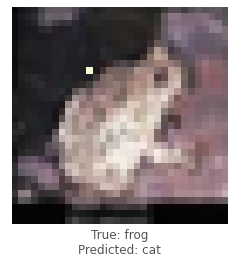


 lenet - image 6632 - 87 / 100


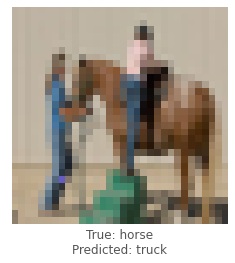


 lenet - image 4659 - 88 / 100


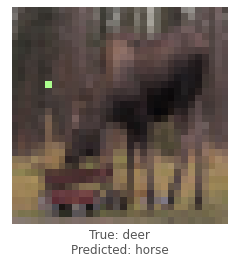


 lenet - image 1051 - 89 / 100


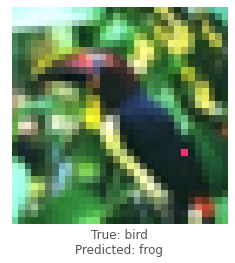


 lenet - image 4649 - 90 / 100


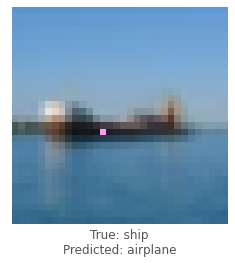


 lenet - image 8083 - 91 / 100


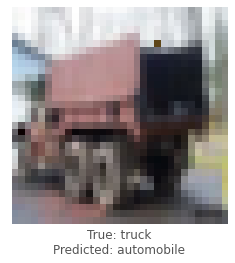


 lenet - image 4180 - 92 / 100


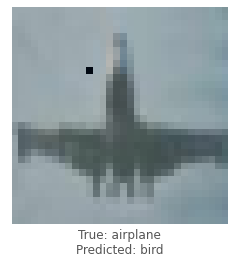


 lenet - image 3187 - 93 / 100


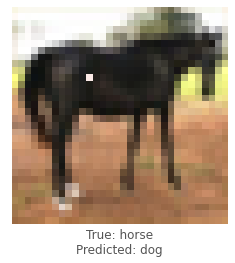


 lenet - image 1578 - 94 / 100


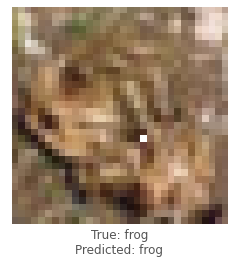


 lenet - image 4168 - 95 / 100


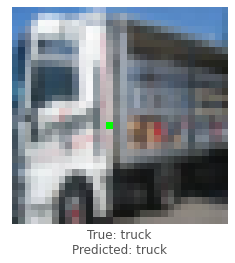


 lenet - image 5141 - 96 / 100


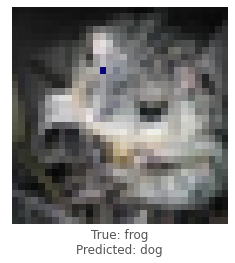


 lenet - image 639 - 97 / 100


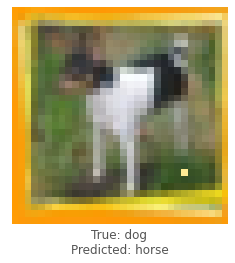


 lenet - image 298 - 98 / 100


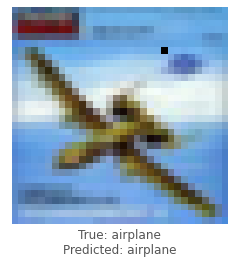


 lenet - image 9451 - 99 / 100


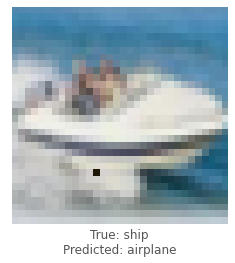


 lenet - image 9444 - 100 / 100


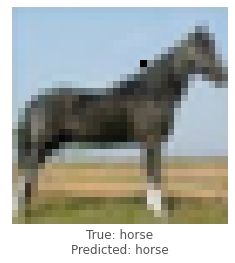


 lenet - image 2918 - 1 / 100


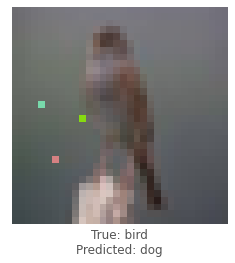


 lenet - image 3941 - 2 / 100


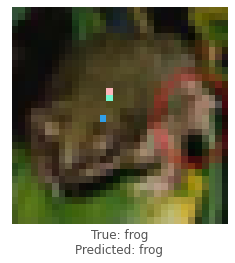


 lenet - image 1257 - 3 / 100


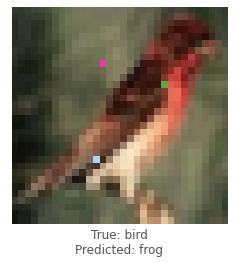


 lenet - image 5766 - 4 / 100


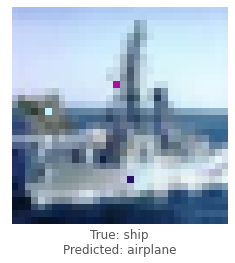


 lenet - image 1045 - 5 / 100


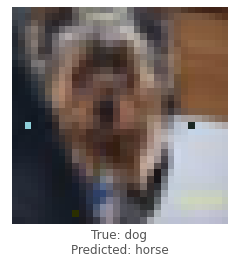


 lenet - image 2819 - 6 / 100


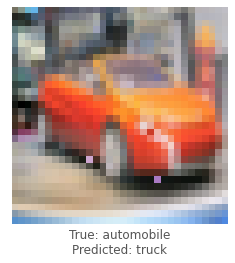


 lenet - image 2295 - 7 / 100


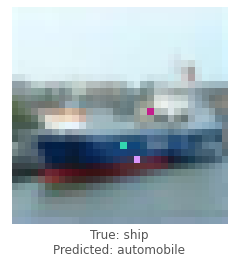


 lenet - image 7520 - 8 / 100


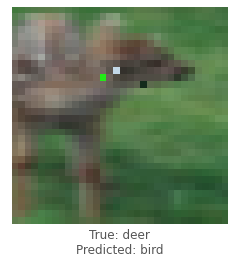


 lenet - image 4743 - 9 / 100


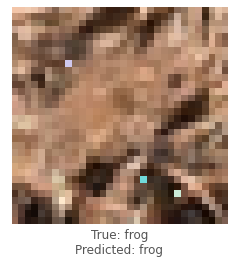


 lenet - image 7677 - 10 / 100


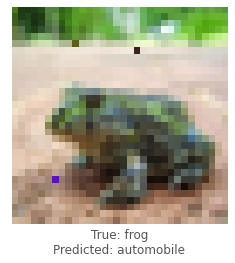


 lenet - image 9183 - 11 / 100


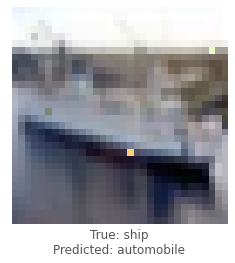


 lenet - image 3529 - 12 / 100


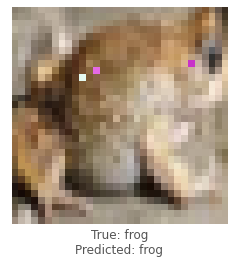


 lenet - image 5217 - 13 / 100


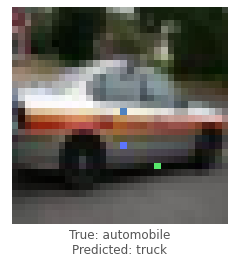


 lenet - image 4638 - 14 / 100


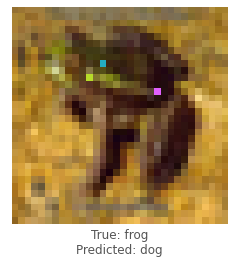


 lenet - image 6967 - 15 / 100


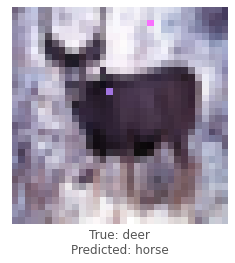


 lenet - image 9025 - 16 / 100


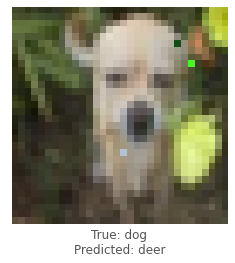


 lenet - image 6053 - 17 / 100


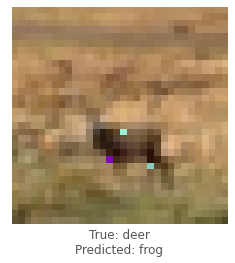


 lenet - image 4640 - 18 / 100


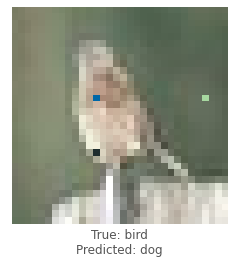


 lenet - image 976 - 19 / 100


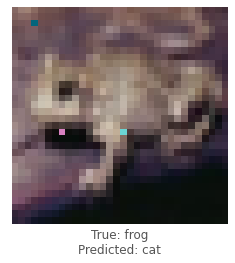


 lenet - image 9408 - 20 / 100


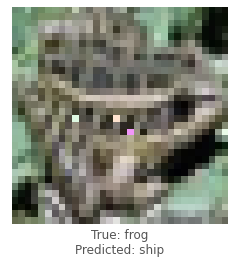


 lenet - image 3689 - 21 / 100


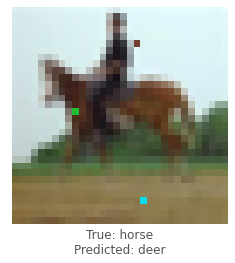


 lenet - image 6154 - 22 / 100


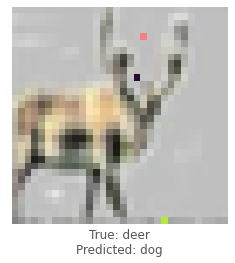


 lenet - image 9925 - 23 / 100


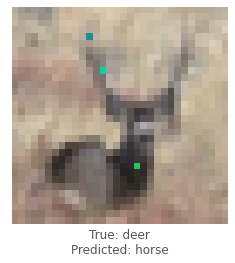


 lenet - image 3437 - 24 / 100


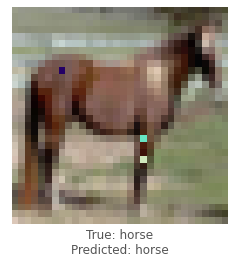


 lenet - image 197 - 25 / 100


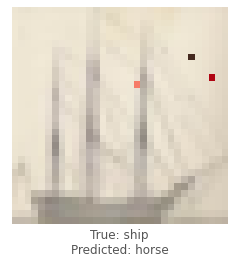


 lenet - image 6358 - 26 / 100


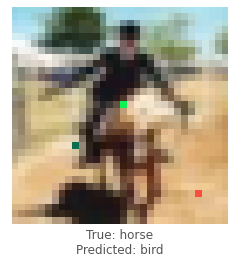


 lenet - image 2849 - 27 / 100


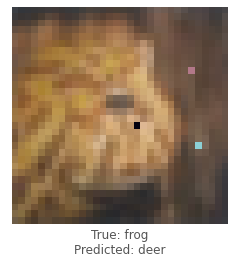


 lenet - image 3326 - 28 / 100


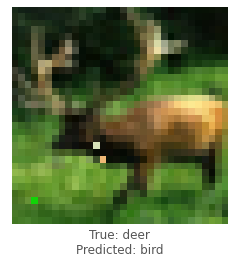


 lenet - image 7820 - 29 / 100


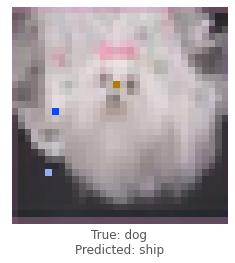


 lenet - image 7577 - 30 / 100


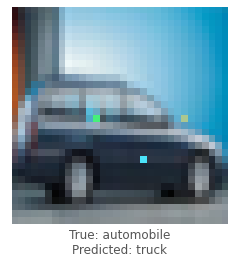


 lenet - image 3248 - 31 / 100


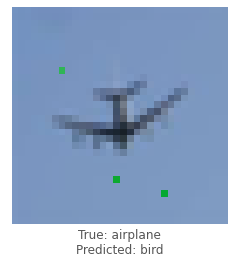


 lenet - image 1357 - 32 / 100


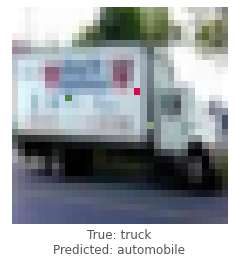


 lenet - image 455 - 33 / 100


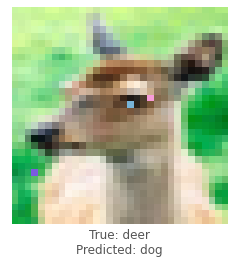


 lenet - image 1365 - 34 / 100


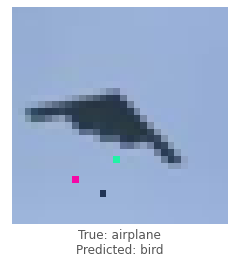


 lenet - image 6140 - 35 / 100


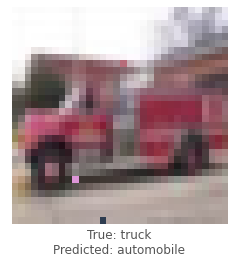


 lenet - image 4670 - 36 / 100


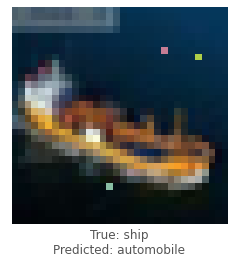


 lenet - image 8669 - 37 / 100


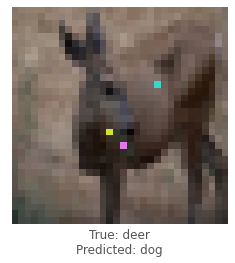


 lenet - image 2056 - 38 / 100


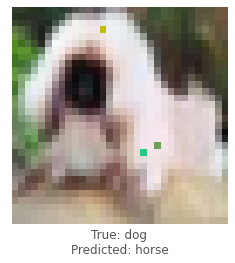


 lenet - image 7315 - 39 / 100


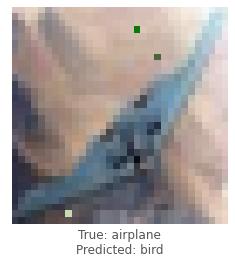


 lenet - image 1498 - 40 / 100


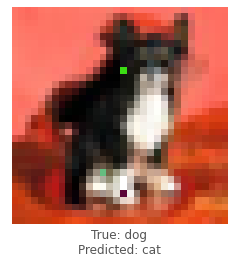


 lenet - image 7335 - 41 / 100


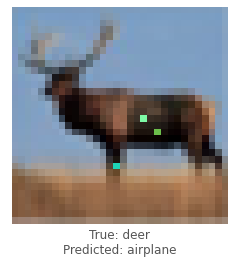


 lenet - image 1833 - 42 / 100


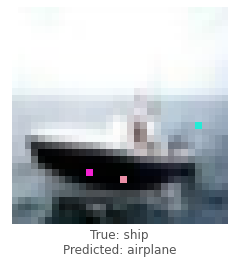


 lenet - image 3876 - 43 / 100


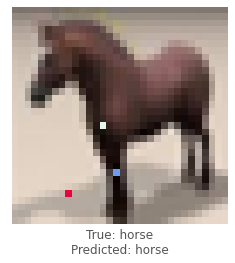


 lenet - image 8546 - 44 / 100


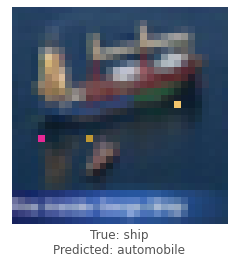


 lenet - image 2794 - 45 / 100


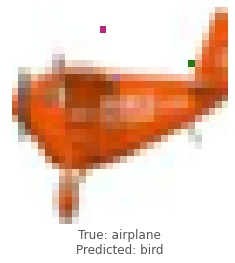


 lenet - image 1143 - 46 / 100


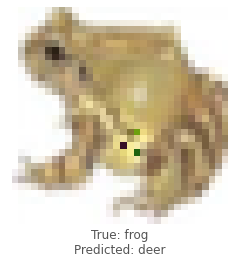


 lenet - image 7565 - 47 / 100


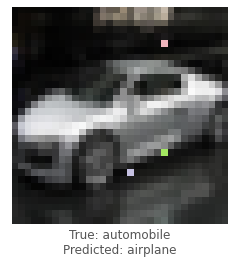


 lenet - image 4644 - 48 / 100


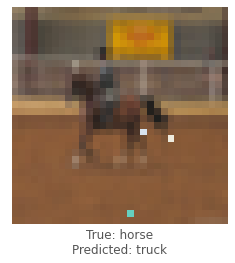


 lenet - image 8989 - 49 / 100


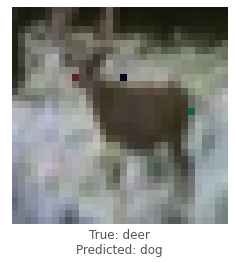


 lenet - image 8971 - 50 / 100


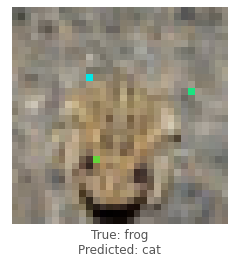


 lenet - image 1661 - 51 / 100


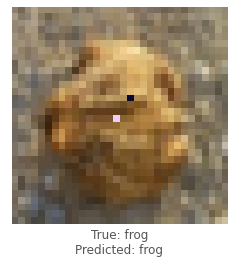


 lenet - image 344 - 52 / 100


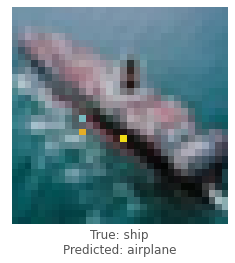


 lenet - image 8249 - 53 / 100


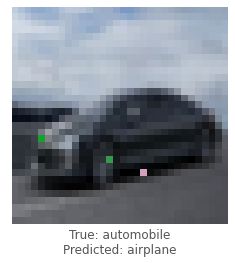


 lenet - image 6758 - 54 / 100


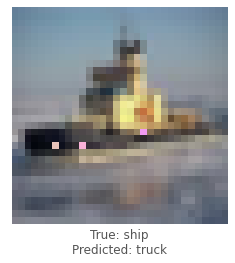


 lenet - image 5686 - 55 / 100


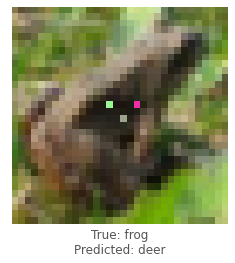


 lenet - image 9101 - 56 / 100


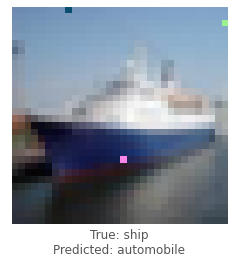


 lenet - image 2454 - 57 / 100


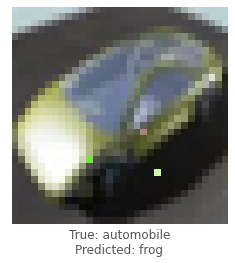


 lenet - image 9736 - 58 / 100


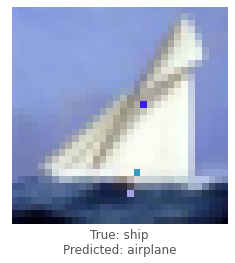


 lenet - image 506 - 59 / 100


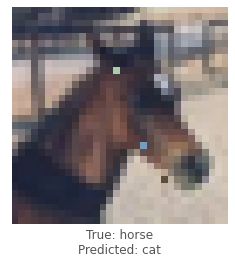


 lenet - image 4657 - 60 / 100


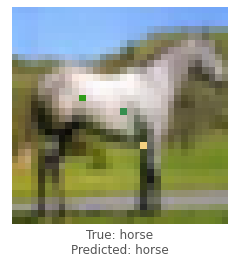


 lenet - image 7144 - 61 / 100


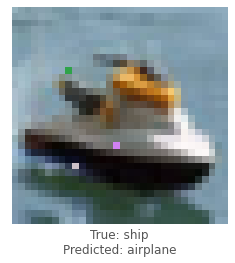


 lenet - image 7737 - 62 / 100


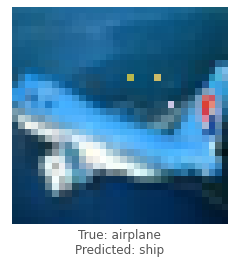


 lenet - image 9956 - 63 / 100


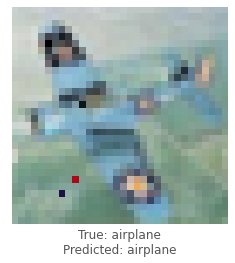


 lenet - image 9278 - 64 / 100


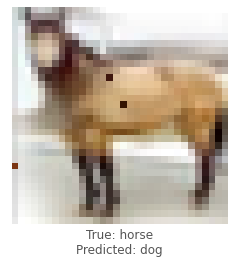


 lenet - image 1541 - 65 / 100


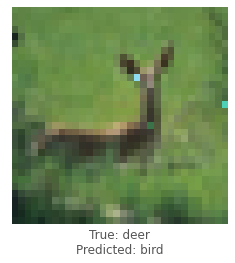


 lenet - image 4893 - 66 / 100


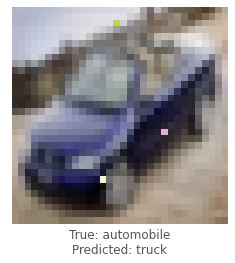


 lenet - image 6327 - 67 / 100


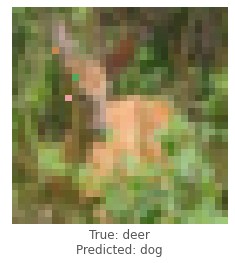


 lenet - image 3794 - 68 / 100


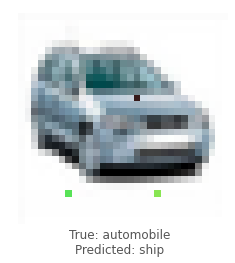


 lenet - image 7331 - 69 / 100


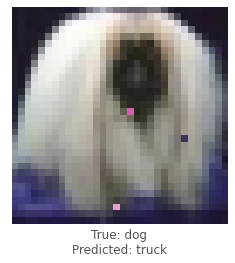


 lenet - image 7409 - 70 / 100


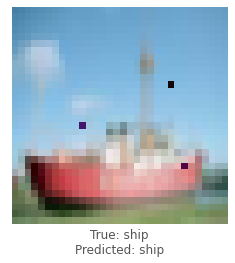


 lenet - image 7687 - 71 / 100


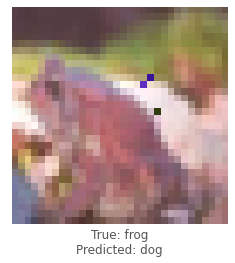


 lenet - image 6475 - 72 / 100


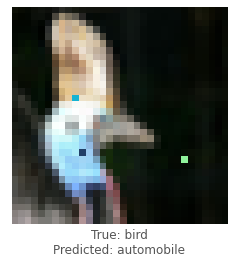


 lenet - image 5692 - 73 / 100


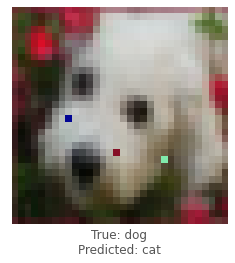


 lenet - image 656 - 74 / 100


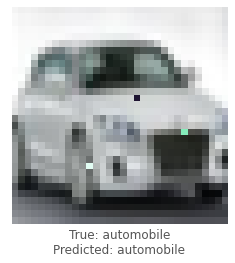


 lenet - image 7476 - 75 / 100


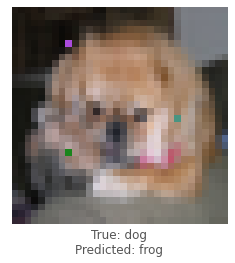


 lenet - image 3718 - 76 / 100


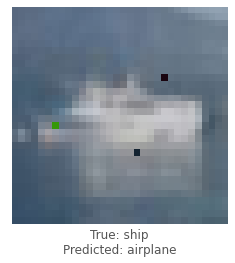


 lenet - image 890 - 77 / 100


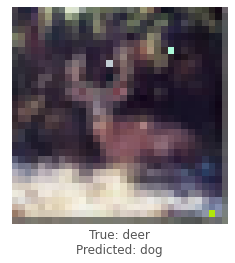


 lenet - image 3212 - 78 / 100


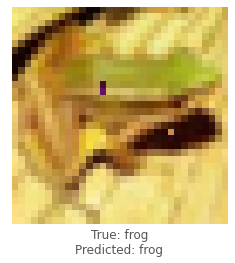


 lenet - image 9435 - 79 / 100


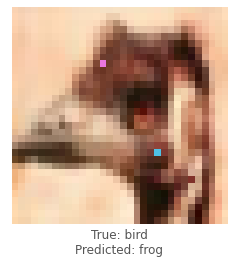


 lenet - image 6375 - 80 / 100


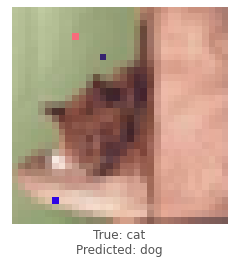


 lenet - image 2622 - 81 / 100


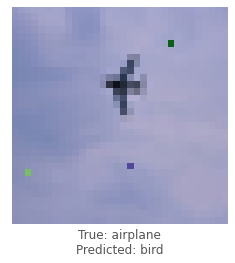


 lenet - image 9014 - 82 / 100


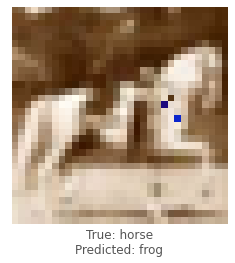


 lenet - image 6613 - 83 / 100


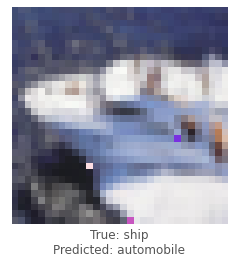


 lenet - image 7208 - 84 / 100


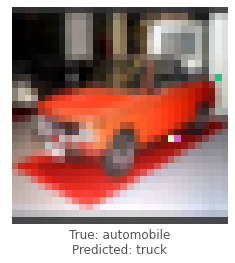


 lenet - image 4202 - 85 / 100


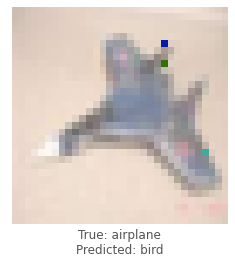


 lenet - image 9488 - 86 / 100


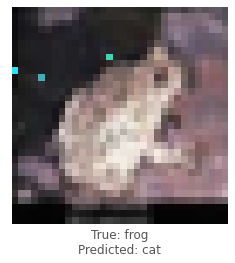


 lenet - image 6632 - 87 / 100


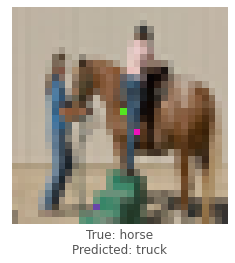


 lenet - image 4659 - 88 / 100


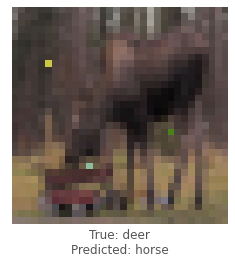


 lenet - image 1051 - 89 / 100


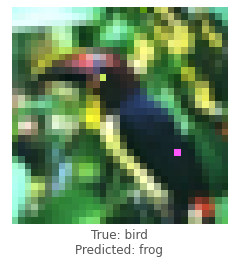


 lenet - image 4649 - 90 / 100


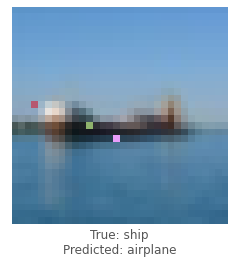


 lenet - image 8083 - 91 / 100


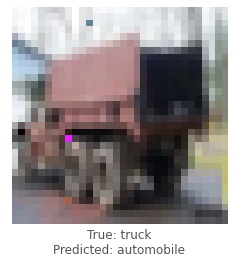


 lenet - image 4180 - 92 / 100


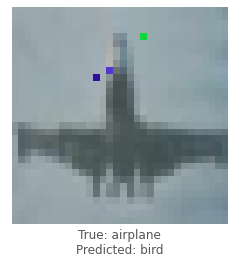


 lenet - image 3187 - 93 / 100


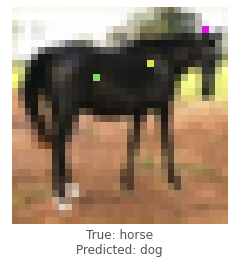


 lenet - image 1578 - 94 / 100


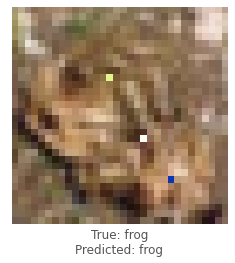


 lenet - image 4168 - 95 / 100


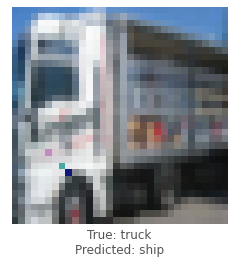


 lenet - image 5141 - 96 / 100


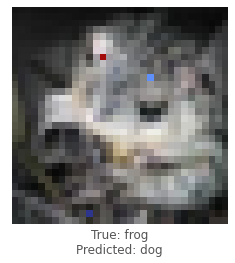


 lenet - image 639 - 97 / 100


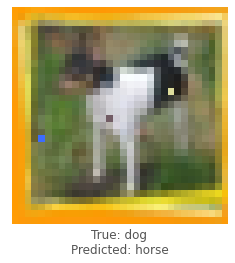


 lenet - image 298 - 98 / 100


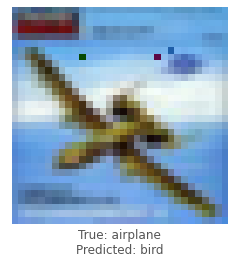


 lenet - image 9451 - 99 / 100


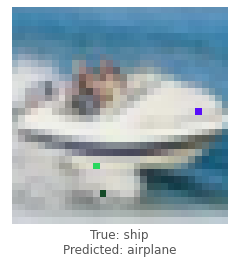


 lenet - image 9444 - 100 / 100


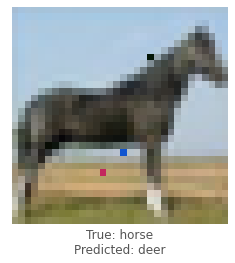


 lenet - image 2918 - 1 / 100


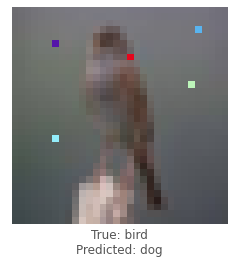


 lenet - image 3941 - 2 / 100


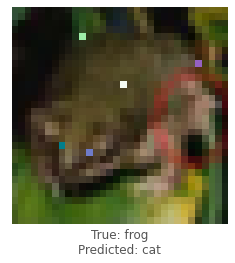


 lenet - image 1257 - 3 / 100


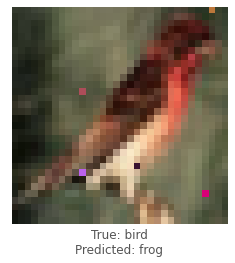


 lenet - image 5766 - 4 / 100


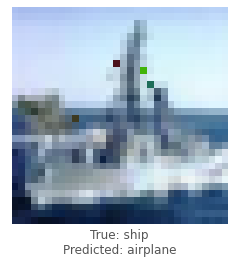


 lenet - image 1045 - 5 / 100


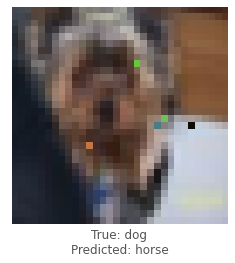


 lenet - image 2819 - 6 / 100


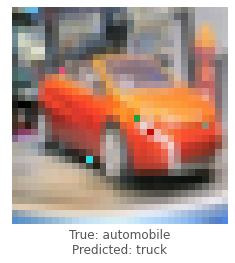


 lenet - image 2295 - 7 / 100


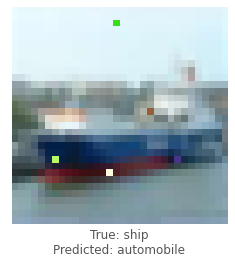


 lenet - image 7520 - 8 / 100


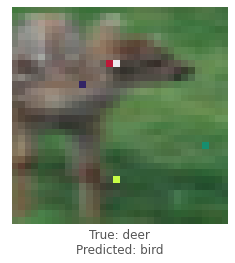


 lenet - image 4743 - 9 / 100


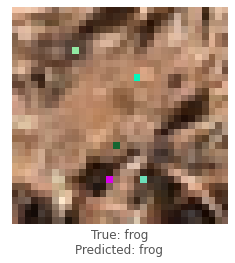


 lenet - image 7677 - 10 / 100


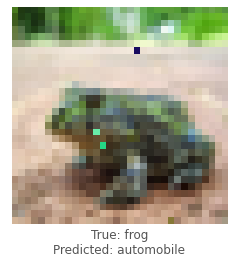


 lenet - image 9183 - 11 / 100


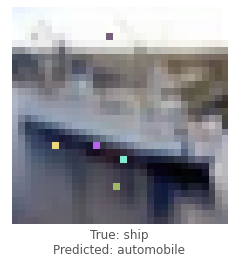


 lenet - image 3529 - 12 / 100


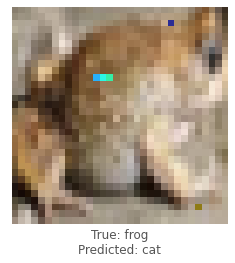


 lenet - image 5217 - 13 / 100


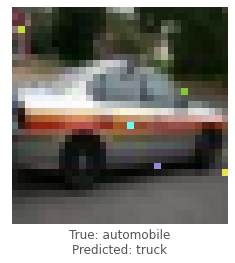


 lenet - image 4638 - 14 / 100


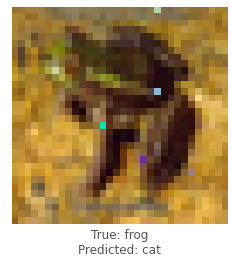


 lenet - image 6967 - 15 / 100


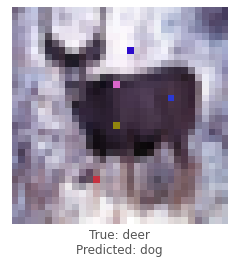


 lenet - image 9025 - 16 / 100


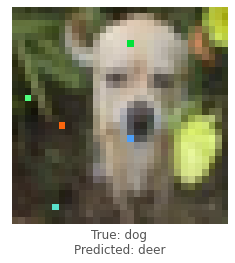


 lenet - image 6053 - 17 / 100


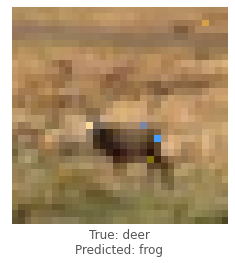


 lenet - image 4640 - 18 / 100


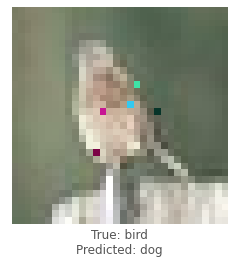


 lenet - image 976 - 19 / 100


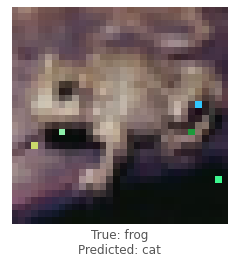


 lenet - image 9408 - 20 / 100


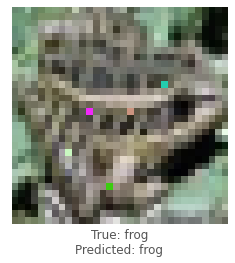


 lenet - image 3689 - 21 / 100


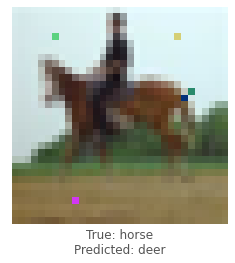


 lenet - image 6154 - 22 / 100


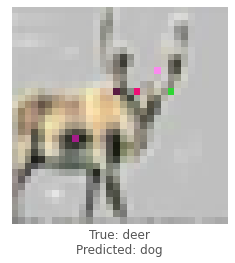


 lenet - image 9925 - 23 / 100


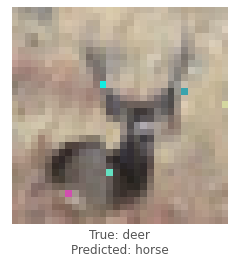


 lenet - image 3437 - 24 / 100


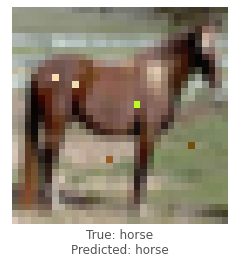


 lenet - image 197 - 25 / 100


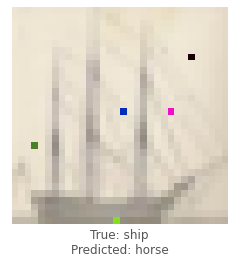


 lenet - image 6358 - 26 / 100


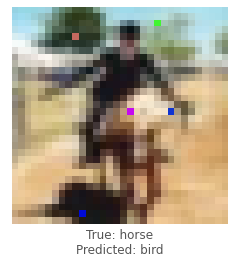


 lenet - image 2849 - 27 / 100


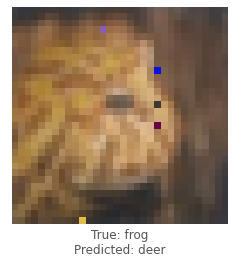


 lenet - image 3326 - 28 / 100


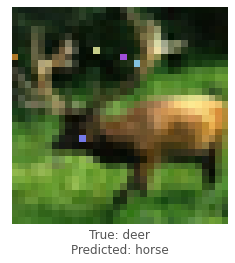


 lenet - image 7820 - 29 / 100


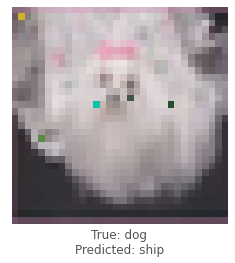


 lenet - image 7577 - 30 / 100


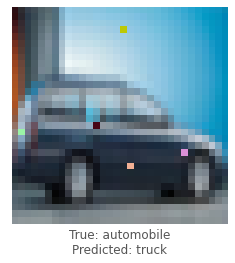


 lenet - image 3248 - 31 / 100


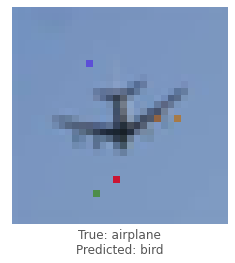


 lenet - image 1357 - 32 / 100


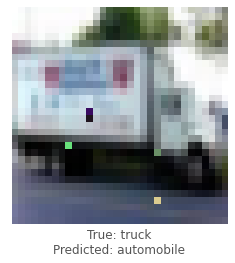


 lenet - image 455 - 33 / 100


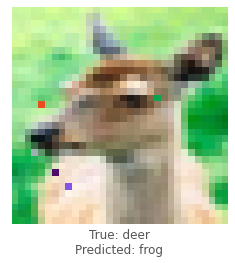


 lenet - image 1365 - 34 / 100


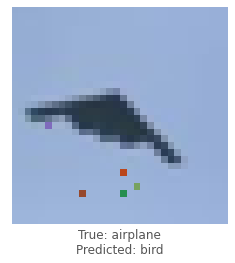


 lenet - image 6140 - 35 / 100


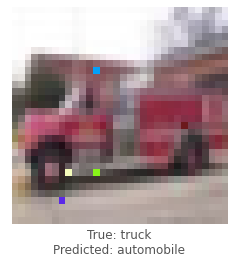


 lenet - image 4670 - 36 / 100


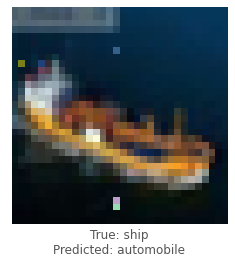


 lenet - image 8669 - 37 / 100


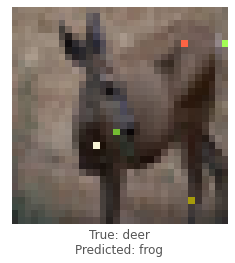


 lenet - image 2056 - 38 / 100


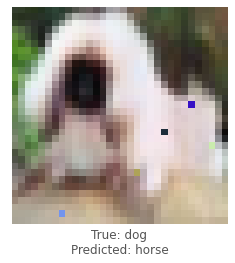


 lenet - image 7315 - 39 / 100


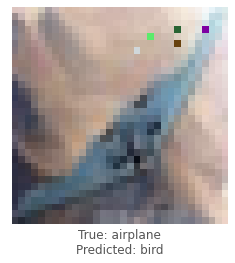


 lenet - image 1498 - 40 / 100


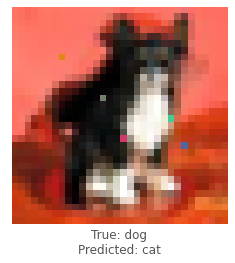


 lenet - image 7335 - 41 / 100


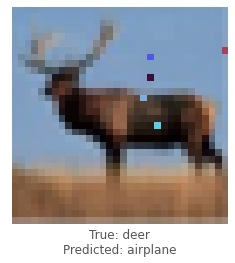


 lenet - image 1833 - 42 / 100


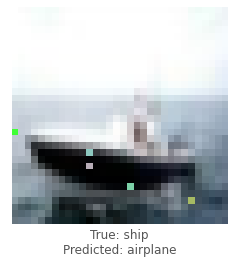


 lenet - image 3876 - 43 / 100


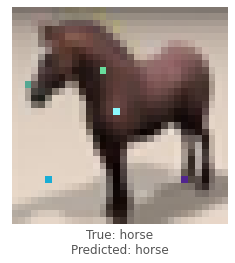


 lenet - image 8546 - 44 / 100


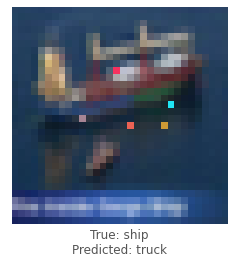


 lenet - image 2794 - 45 / 100


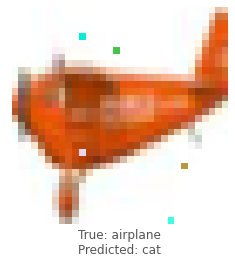


 lenet - image 1143 - 46 / 100


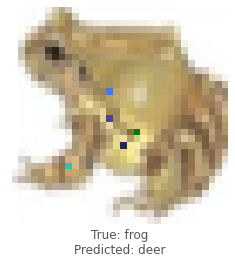


 lenet - image 7565 - 47 / 100


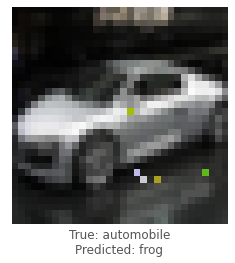


 lenet - image 4644 - 48 / 100


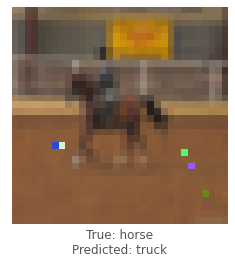


 lenet - image 8989 - 49 / 100


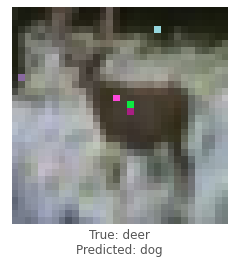


 lenet - image 8971 - 50 / 100


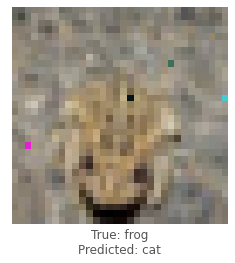


 lenet - image 1661 - 51 / 100


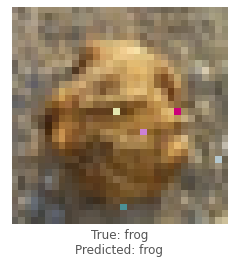


 lenet - image 344 - 52 / 100


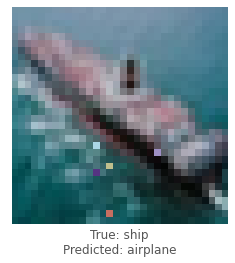


 lenet - image 8249 - 53 / 100


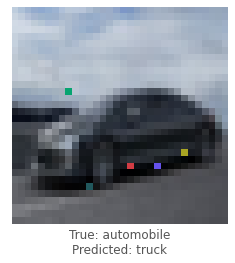


 lenet - image 6758 - 54 / 100


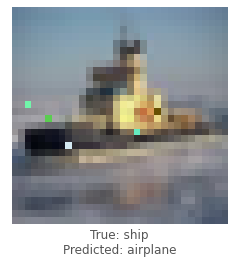


 lenet - image 5686 - 55 / 100


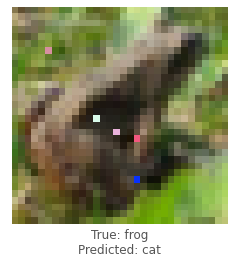


 lenet - image 9101 - 56 / 100


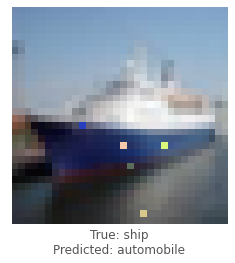


 lenet - image 2454 - 57 / 100


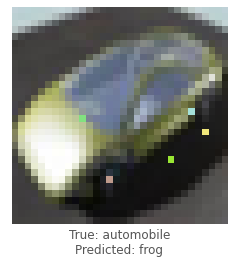


 lenet - image 9736 - 58 / 100


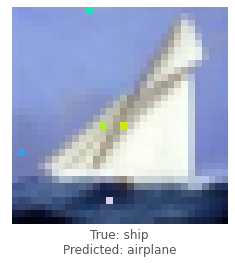


 lenet - image 506 - 59 / 100


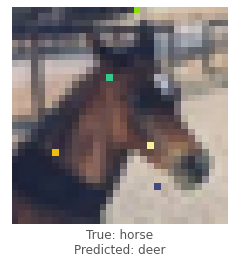


 lenet - image 4657 - 60 / 100


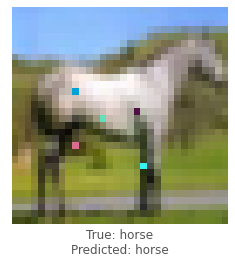


 lenet - image 7144 - 61 / 100


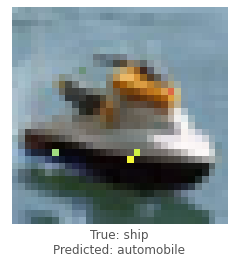


 lenet - image 7737 - 62 / 100


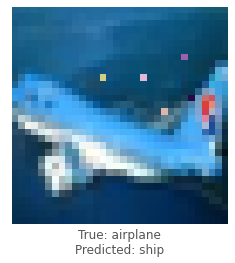


 lenet - image 9956 - 63 / 100


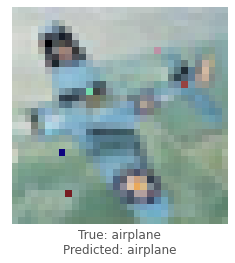


 lenet - image 9278 - 64 / 100


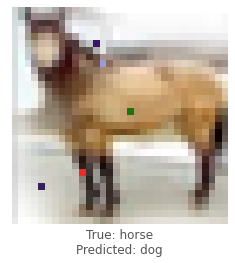


 lenet - image 1541 - 65 / 100


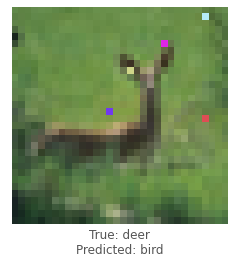


 lenet - image 4893 - 66 / 100


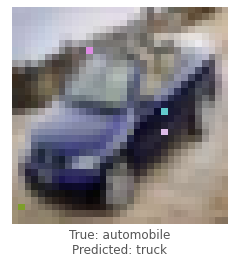


 lenet - image 6327 - 67 / 100


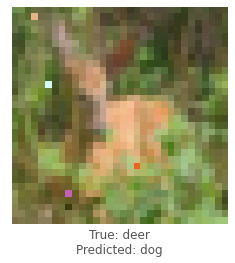


 lenet - image 3794 - 68 / 100


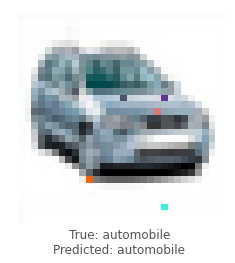


 lenet - image 7331 - 69 / 100


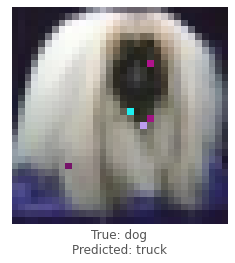


 lenet - image 7409 - 70 / 100


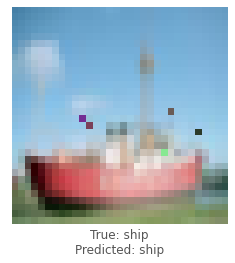


 lenet - image 7687 - 71 / 100


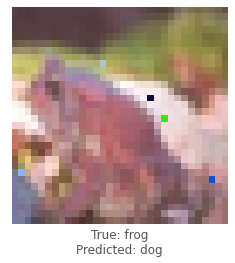


 lenet - image 6475 - 72 / 100


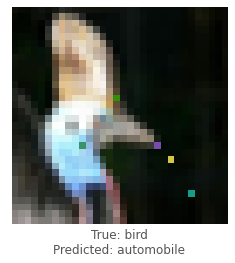


 lenet - image 5692 - 73 / 100


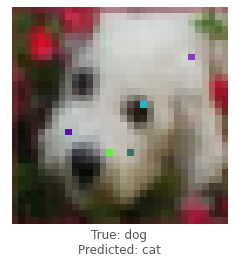


 lenet - image 656 - 74 / 100


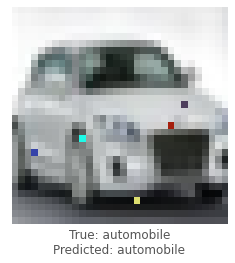


 lenet - image 7476 - 75 / 100


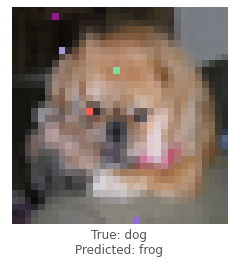


 lenet - image 3718 - 76 / 100


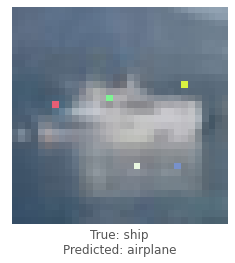


 lenet - image 890 - 77 / 100


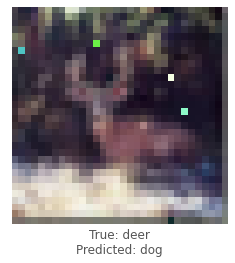


 lenet - image 3212 - 78 / 100


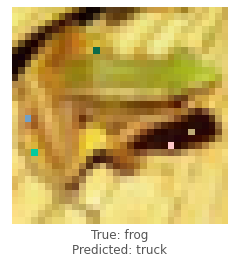


 lenet - image 9435 - 79 / 100


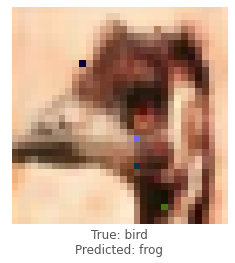


 lenet - image 6375 - 80 / 100


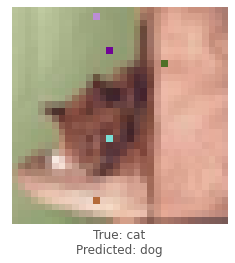


 lenet - image 2622 - 81 / 100


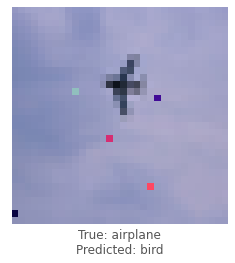


 lenet - image 9014 - 82 / 100


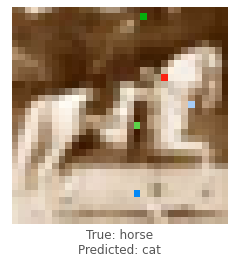


 lenet - image 6613 - 83 / 100


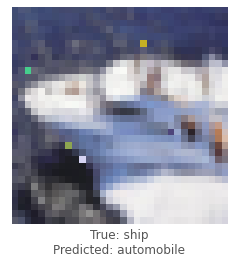


 lenet - image 7208 - 84 / 100


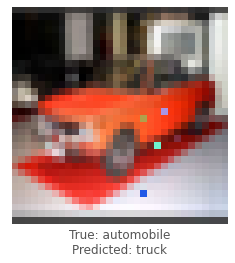


 lenet - image 4202 - 85 / 100


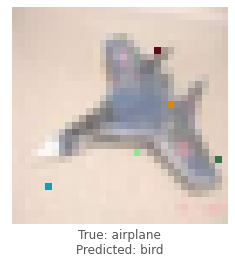


 lenet - image 9488 - 86 / 100


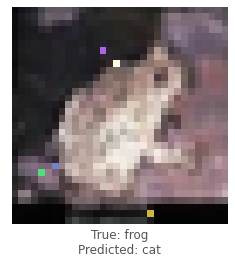


 lenet - image 6632 - 87 / 100


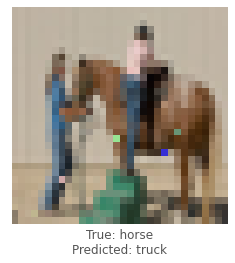


 lenet - image 4659 - 88 / 100


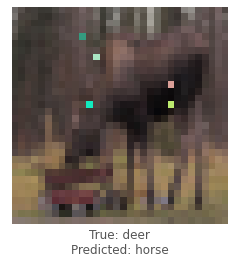


 lenet - image 1051 - 89 / 100


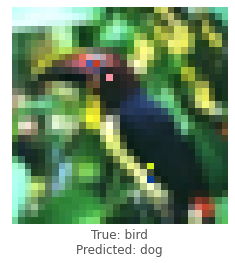


 lenet - image 4649 - 90 / 100


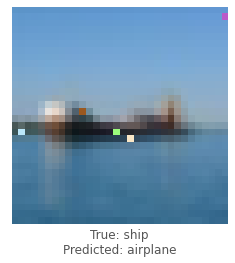


 lenet - image 8083 - 91 / 100


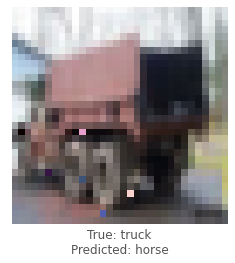


 lenet - image 4180 - 92 / 100


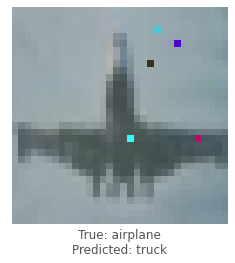


 lenet - image 3187 - 93 / 100


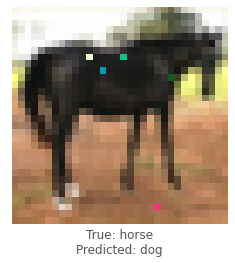


 lenet - image 1578 - 94 / 100


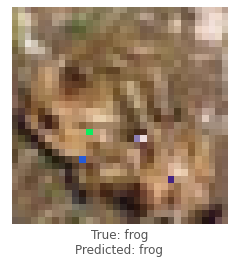


 lenet - image 4168 - 95 / 100


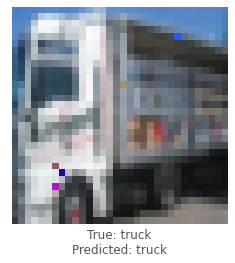


 lenet - image 5141 - 96 / 100


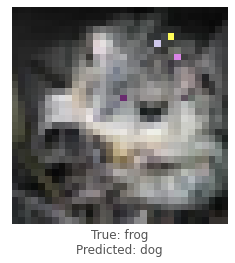


 lenet - image 639 - 97 / 100


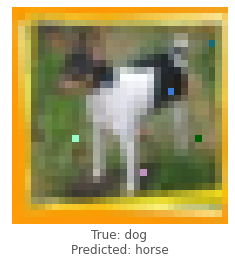


 lenet - image 298 - 98 / 100


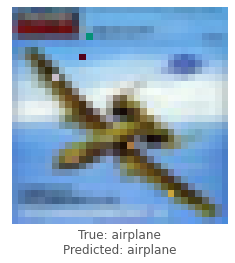


 lenet - image 9451 - 99 / 100


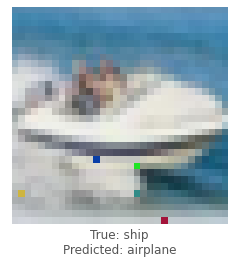


 lenet - image 9444 - 100 / 100


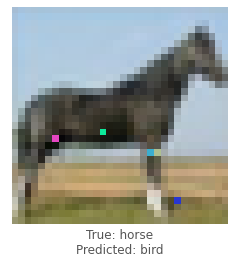


 resnet - image 7022 - 1 / 100


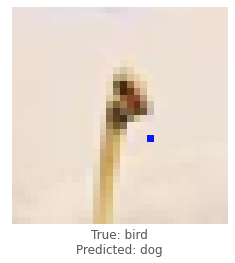


 resnet - image 4137 - 2 / 100


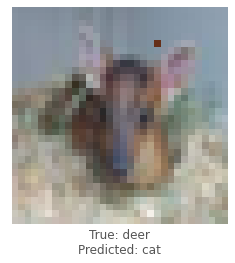


 resnet - image 6757 - 3 / 100


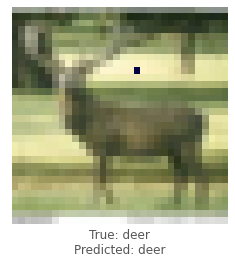


 resnet - image 3024 - 4 / 100


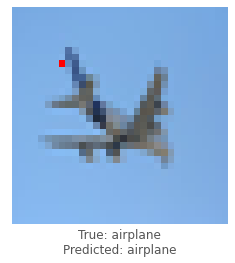


 resnet - image 7069 - 5 / 100


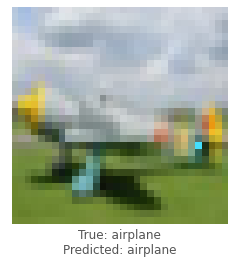


 resnet - image 1527 - 6 / 100


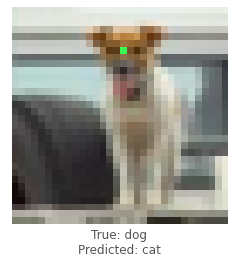


 resnet - image 411 - 7 / 100


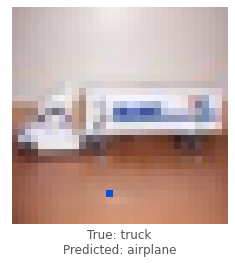


 resnet - image 9251 - 8 / 100


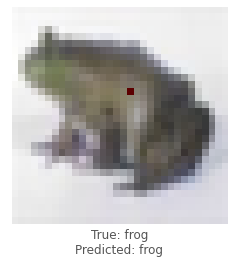


 resnet - image 7672 - 9 / 100


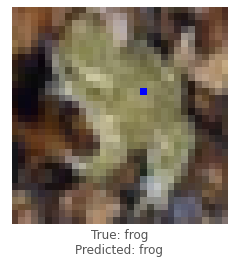


 resnet - image 3000 - 10 / 100


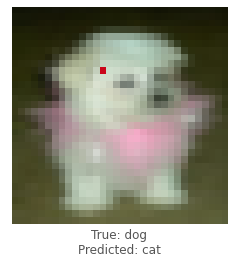


 resnet - image 16 - 11 / 100


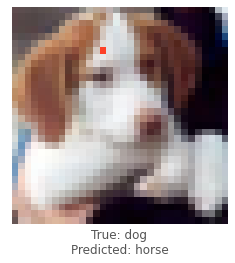


 resnet - image 9974 - 12 / 100


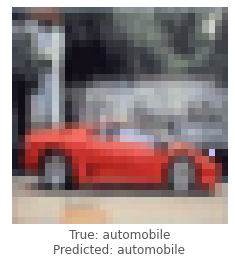


 resnet - image 3693 - 13 / 100


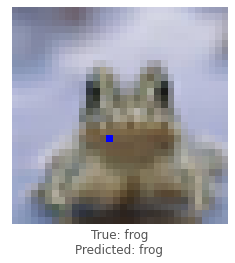


 resnet - image 2975 - 14 / 100


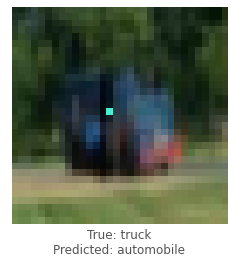


 resnet - image 6907 - 15 / 100


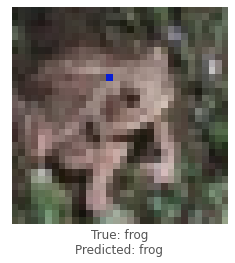


 resnet - image 2997 - 16 / 100


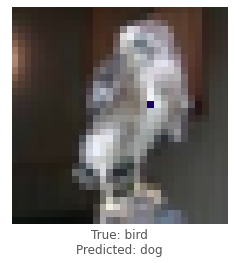


 resnet - image 3419 - 17 / 100


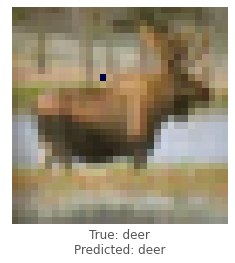


 resnet - image 7441 - 18 / 100


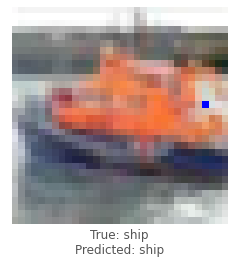


 resnet - image 5389 - 19 / 100


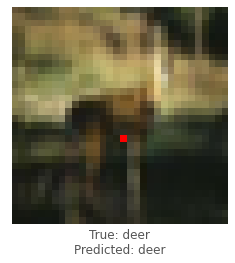


 resnet - image 5479 - 20 / 100


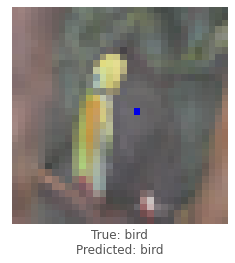


 resnet - image 994 - 21 / 100


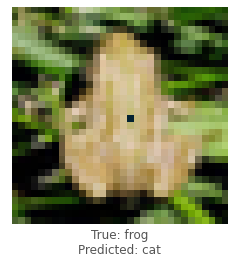


 resnet - image 9232 - 22 / 100


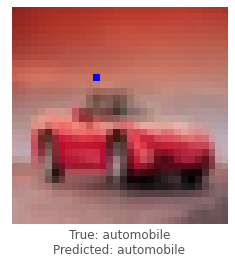


 resnet - image 876 - 23 / 100


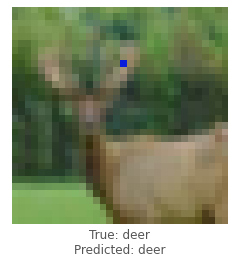


 resnet - image 7964 - 24 / 100


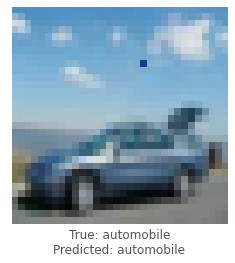


 resnet - image 3425 - 25 / 100


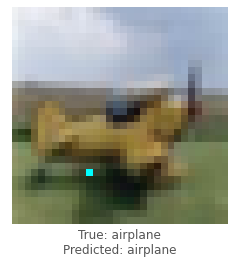


 resnet - image 3841 - 26 / 100


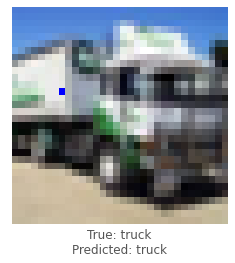


 resnet - image 9293 - 27 / 100


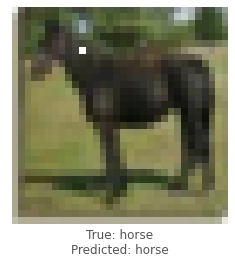


 resnet - image 7158 - 28 / 100


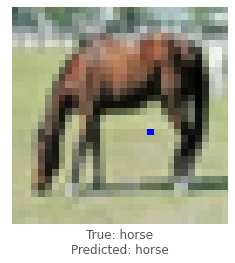


 resnet - image 1670 - 29 / 100


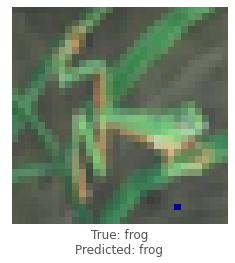


 resnet - image 9921 - 30 / 100


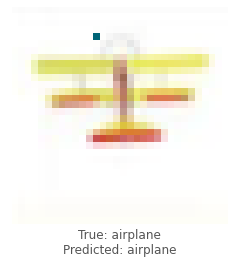


 resnet - image 8539 - 31 / 100


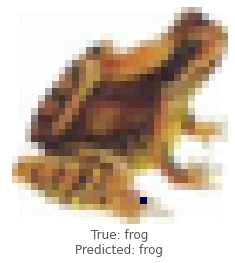


 resnet - image 8423 - 32 / 100


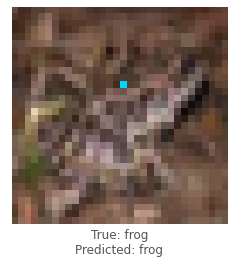


 resnet - image 3703 - 33 / 100


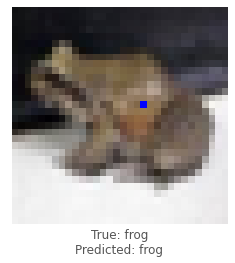


 resnet - image 8620 - 34 / 100


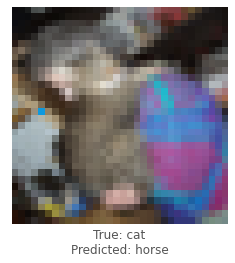


 resnet - image 8448 - 35 / 100


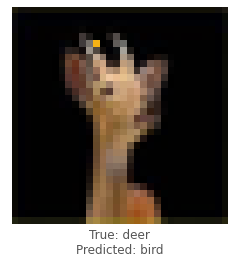


 resnet - image 4185 - 36 / 100


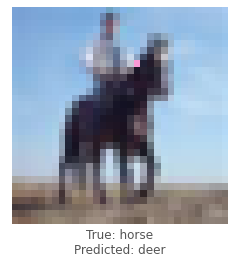


 resnet - image 2416 - 37 / 100


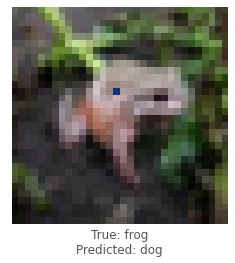


 resnet - image 6639 - 38 / 100


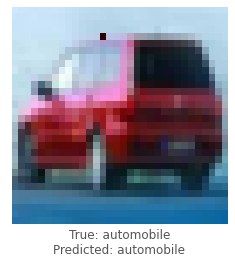


 resnet - image 1603 - 39 / 100


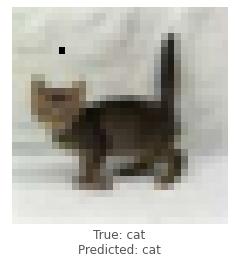


 resnet - image 6274 - 40 / 100


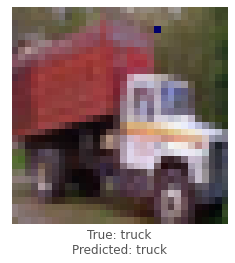


 resnet - image 1881 - 41 / 100


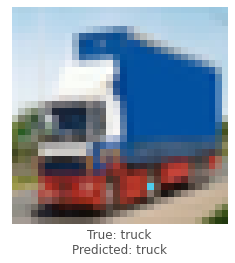


 resnet - image 6156 - 42 / 100


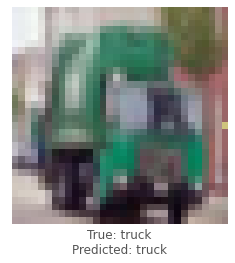


 resnet - image 3238 - 43 / 100


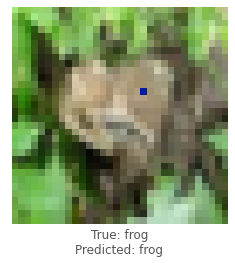


 resnet - image 606 - 44 / 100


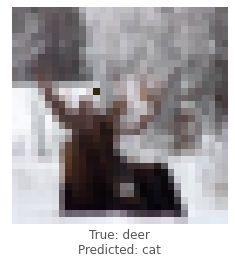


 resnet - image 5717 - 45 / 100


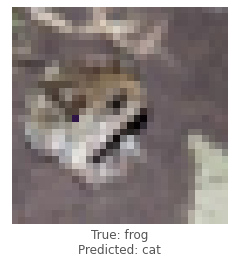


 resnet - image 988 - 46 / 100


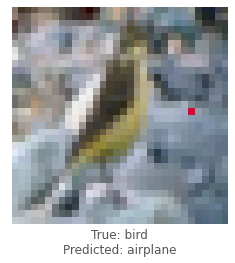


 resnet - image 990 - 47 / 100


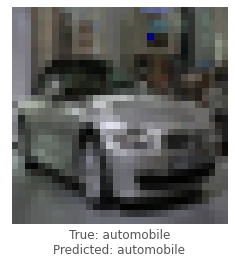


 resnet - image 9700 - 48 / 100


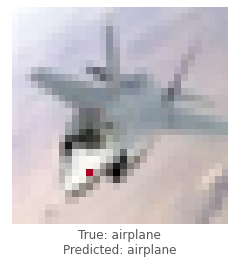


 resnet - image 2009 - 49 / 100


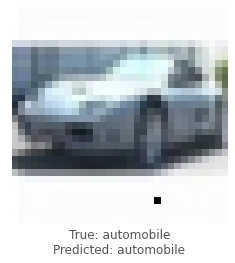


 resnet - image 9745 - 50 / 100


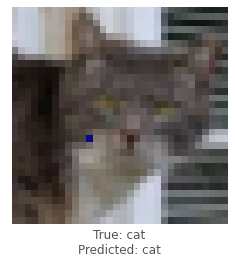


 resnet - image 26 - 51 / 100


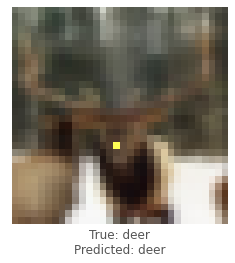


 resnet - image 1133 - 52 / 100


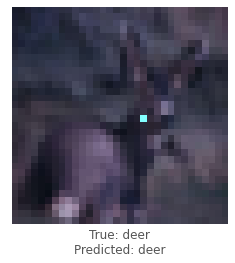


 resnet - image 8137 - 53 / 100


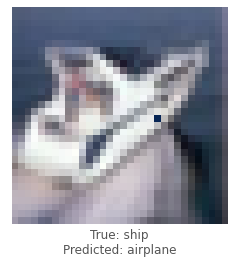


 resnet - image 2642 - 54 / 100


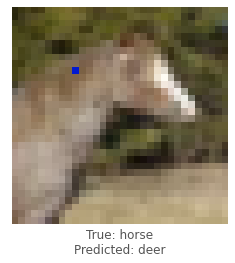


 resnet - image 4203 - 55 / 100


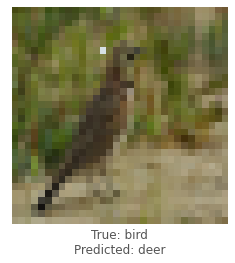


 resnet - image 7957 - 56 / 100


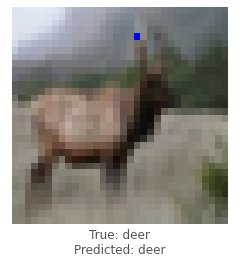


 resnet - image 688 - 57 / 100


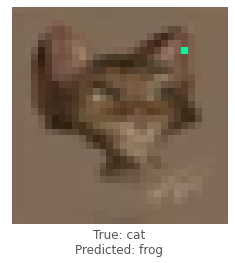


 resnet - image 614 - 58 / 100


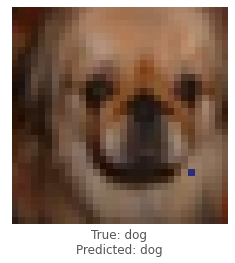


 resnet - image 3084 - 59 / 100


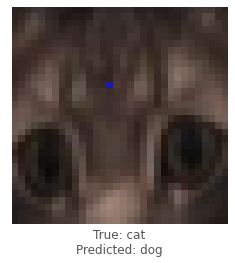


 resnet - image 5392 - 60 / 100


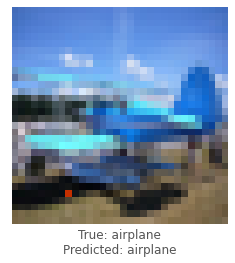


 resnet - image 1859 - 61 / 100


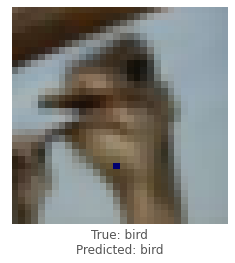


 resnet - image 8183 - 62 / 100


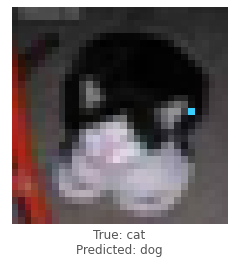


 resnet - image 5303 - 63 / 100


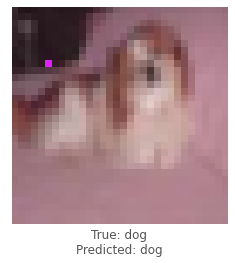


 resnet - image 443 - 64 / 100


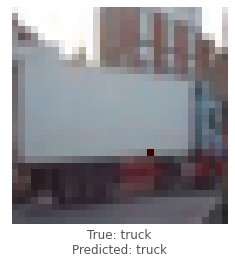


 resnet - image 7604 - 65 / 100


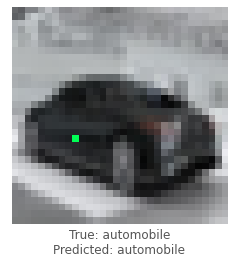


 resnet - image 7307 - 66 / 100


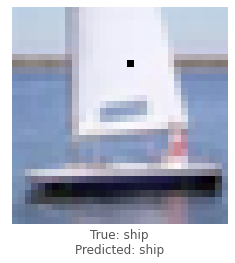


 resnet - image 5586 - 67 / 100


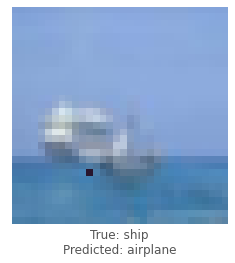


 resnet - image 1483 - 68 / 100


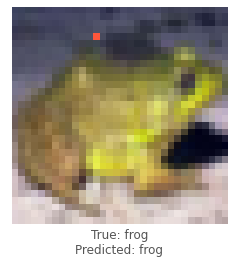


 resnet - image 5512 - 69 / 100


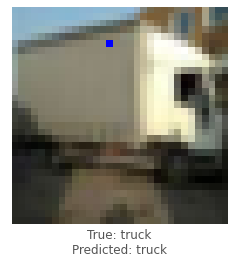


 resnet - image 967 - 70 / 100


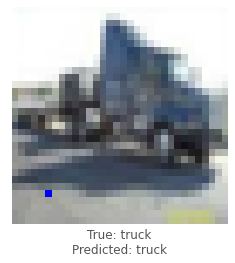


 resnet - image 5738 - 71 / 100


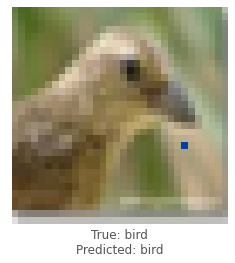


 resnet - image 3213 - 72 / 100


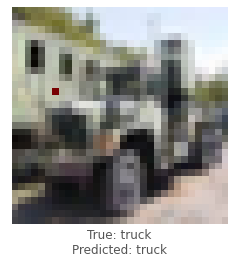


 resnet - image 6683 - 73 / 100


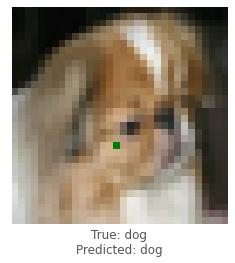


 resnet - image 4074 - 74 / 100


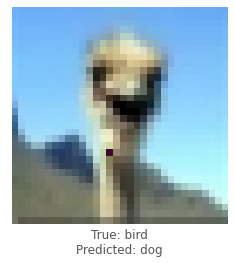


 resnet - image 8820 - 75 / 100


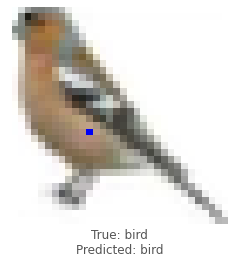


 resnet - image 4028 - 76 / 100


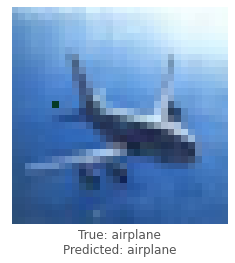


 resnet - image 7390 - 77 / 100


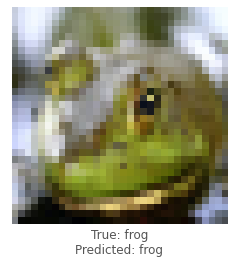


 resnet - image 4584 - 78 / 100


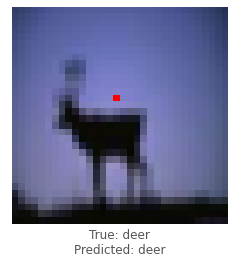


 resnet - image 8111 - 79 / 100


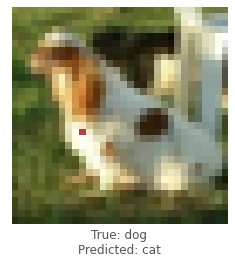


 resnet - image 4274 - 80 / 100


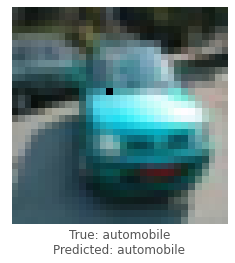


 resnet - image 7191 - 81 / 100


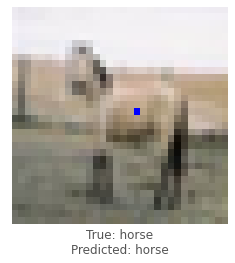


 resnet - image 1650 - 82 / 100


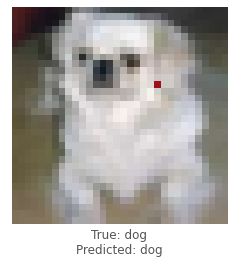


 resnet - image 9189 - 83 / 100


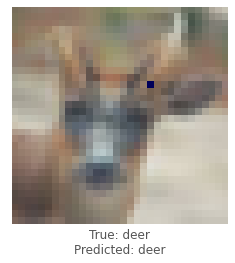


 resnet - image 5959 - 84 / 100


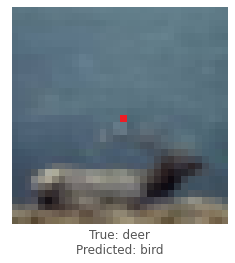


 resnet - image 7084 - 85 / 100


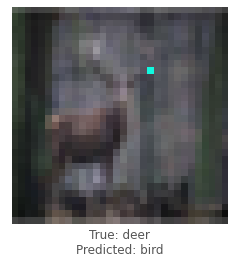


 resnet - image 917 - 86 / 100


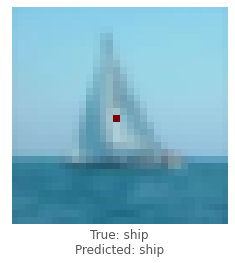


 resnet - image 2030 - 87 / 100


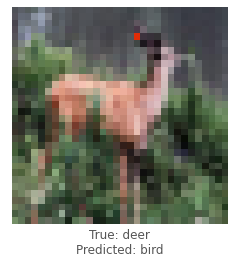


 resnet - image 7062 - 88 / 100


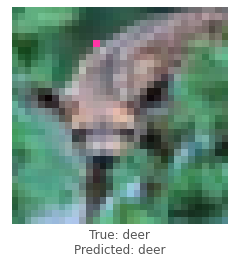


 resnet - image 7770 - 89 / 100


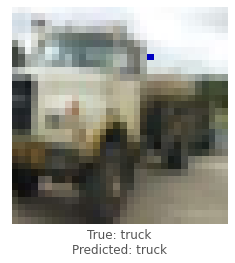


 resnet - image 8670 - 90 / 100


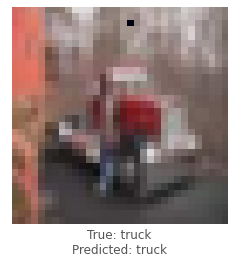


 resnet - image 1503 - 91 / 100


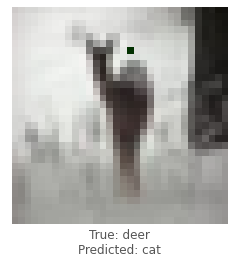


 resnet - image 2887 - 92 / 100


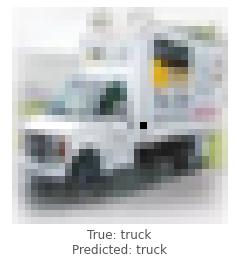


 resnet - image 9547 - 93 / 100


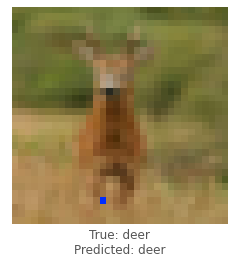


 resnet - image 6167 - 94 / 100


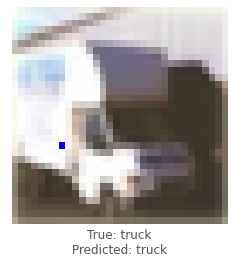


 resnet - image 3541 - 95 / 100


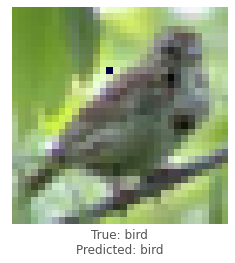


 resnet - image 333 - 96 / 100


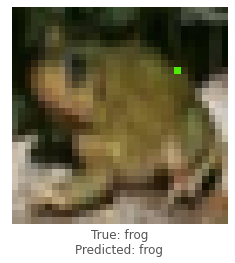


 resnet - image 3046 - 97 / 100


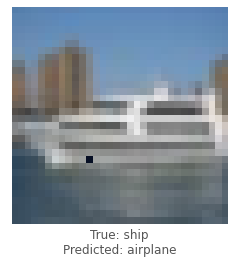


 resnet - image 9125 - 98 / 100


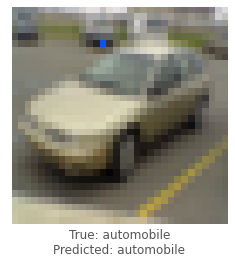


 resnet - image 4913 - 99 / 100


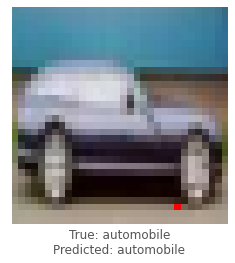


 resnet - image 2717 - 100 / 100


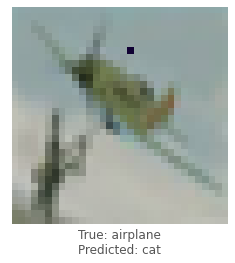


 resnet - image 7022 - 1 / 100


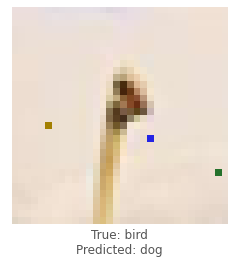


 resnet - image 4137 - 2 / 100


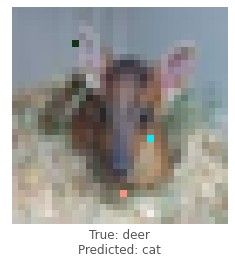


 resnet - image 6757 - 3 / 100


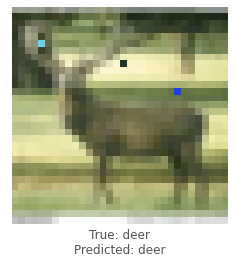


 resnet - image 3024 - 4 / 100


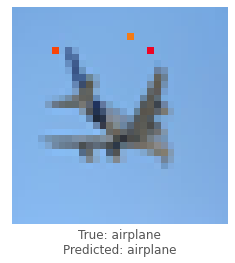


 resnet - image 7069 - 5 / 100


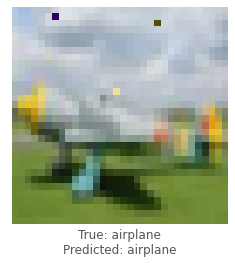


 resnet - image 1527 - 6 / 100


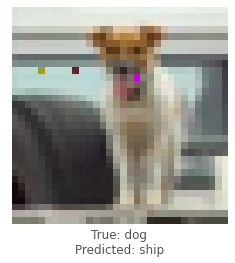


 resnet - image 411 - 7 / 100


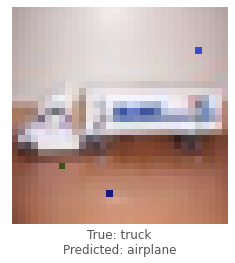


 resnet - image 9251 - 8 / 100


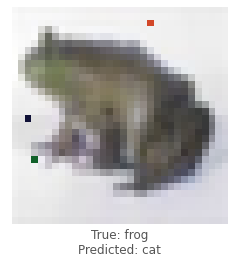


 resnet - image 7672 - 9 / 100


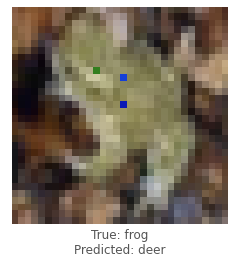


 resnet - image 3000 - 10 / 100


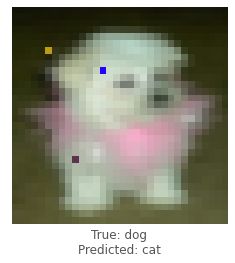


 resnet - image 16 - 11 / 100


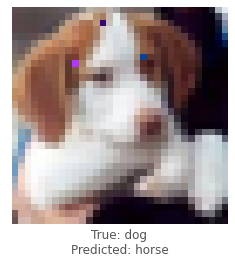


 resnet - image 9974 - 12 / 100


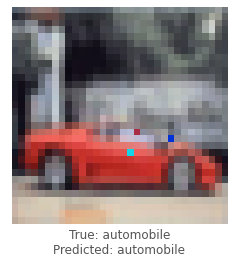


 resnet - image 3693 - 13 / 100


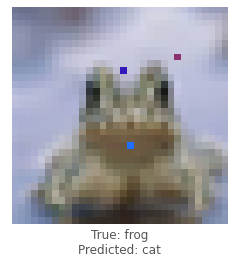


 resnet - image 2975 - 14 / 100


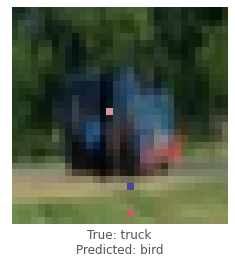


 resnet - image 6907 - 15 / 100


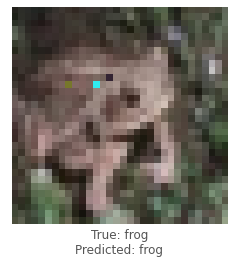


 resnet - image 2997 - 16 / 100


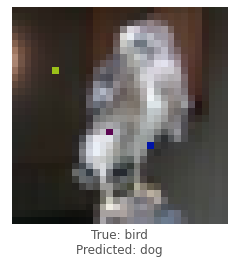


 resnet - image 3419 - 17 / 100


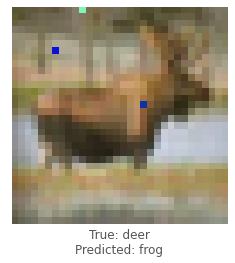


 resnet - image 7441 - 18 / 100


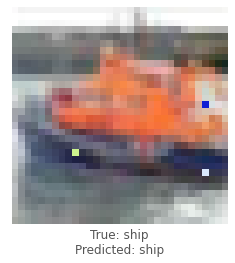


 resnet - image 5389 - 19 / 100


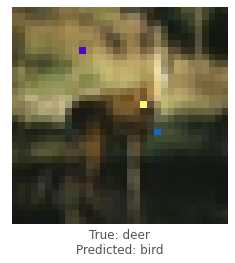


 resnet - image 5479 - 20 / 100


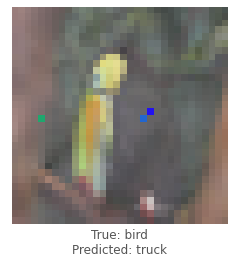


 resnet - image 994 - 21 / 100


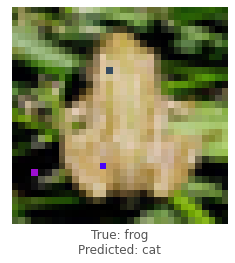


 resnet - image 9232 - 22 / 100


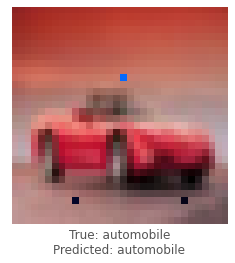


 resnet - image 876 - 23 / 100


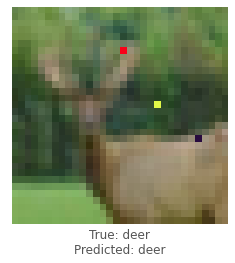


 resnet - image 7964 - 24 / 100


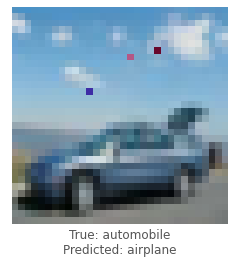


 resnet - image 3425 - 25 / 100


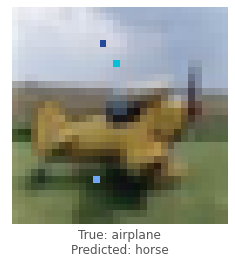


 resnet - image 3841 - 26 / 100


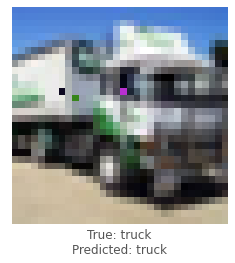


 resnet - image 9293 - 27 / 100


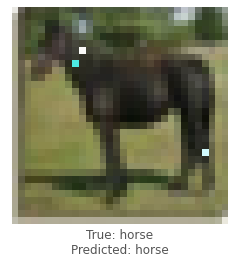


 resnet - image 7158 - 28 / 100


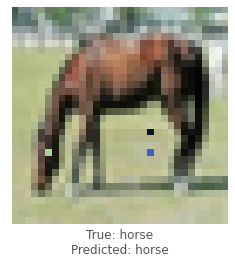


 resnet - image 1670 - 29 / 100


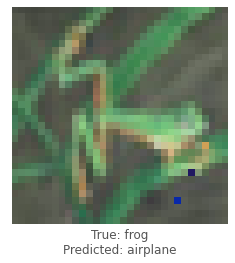


 resnet - image 9921 - 30 / 100


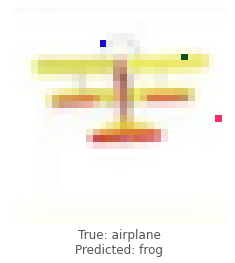


 resnet - image 8539 - 31 / 100


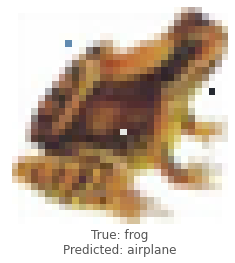


 resnet - image 8423 - 32 / 100


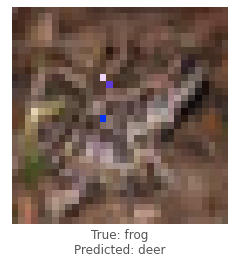


 resnet - image 3703 - 33 / 100


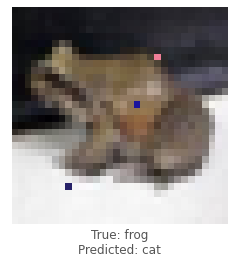


 resnet - image 8620 - 34 / 100


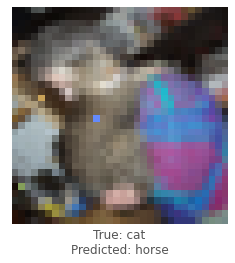


 resnet - image 8448 - 35 / 100


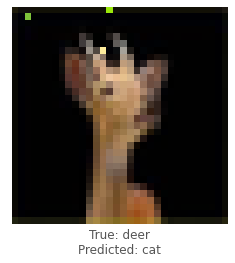


 resnet - image 4185 - 36 / 100


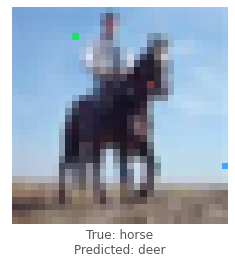


 resnet - image 2416 - 37 / 100


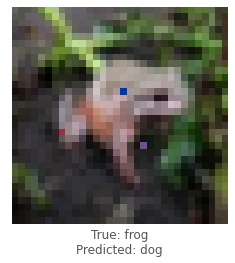


 resnet - image 6639 - 38 / 100


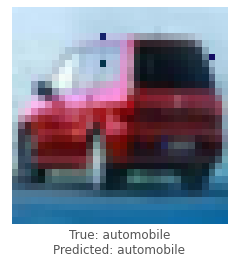


 resnet - image 1603 - 39 / 100


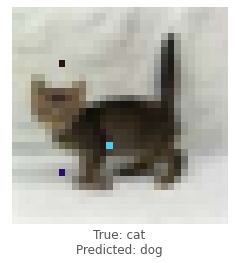


 resnet - image 6274 - 40 / 100


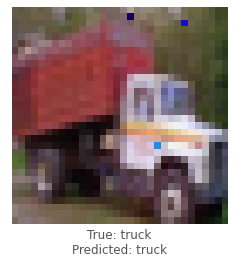


 resnet - image 1881 - 41 / 100


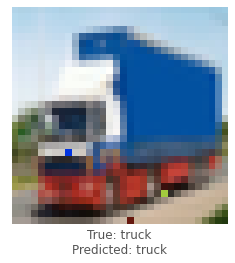


 resnet - image 6156 - 42 / 100


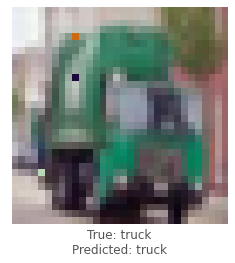


 resnet - image 3238 - 43 / 100


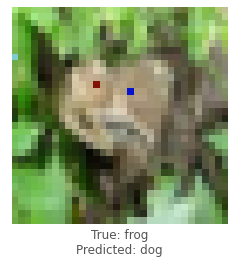


 resnet - image 606 - 44 / 100


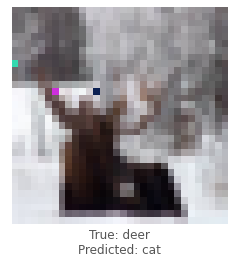


 resnet - image 5717 - 45 / 100


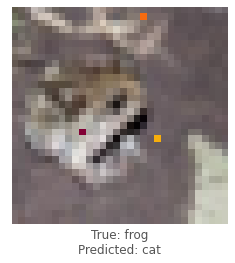


 resnet - image 988 - 46 / 100


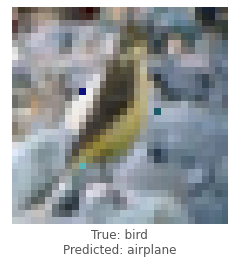


 resnet - image 990 - 47 / 100


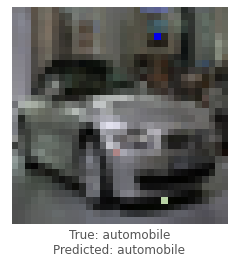


 resnet - image 9700 - 48 / 100


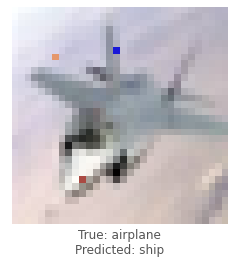


 resnet - image 2009 - 49 / 100


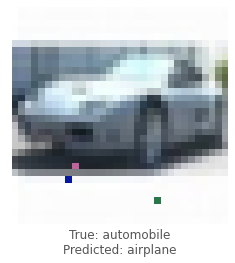


 resnet - image 9745 - 50 / 100


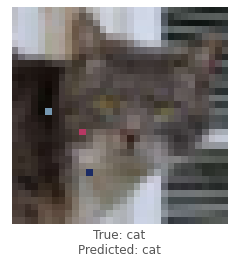


 resnet - image 26 - 51 / 100


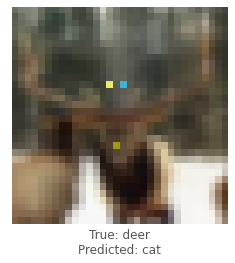


 resnet - image 1133 - 52 / 100


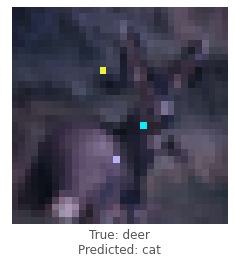


 resnet - image 8137 - 53 / 100


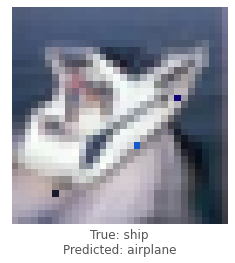


 resnet - image 2642 - 54 / 100


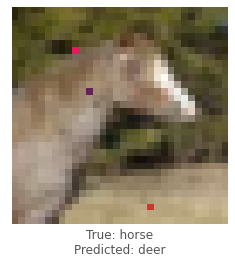


 resnet - image 4203 - 55 / 100


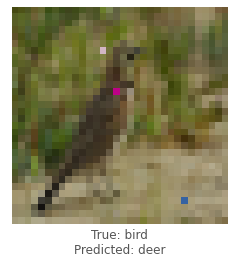


 resnet - image 7957 - 56 / 100


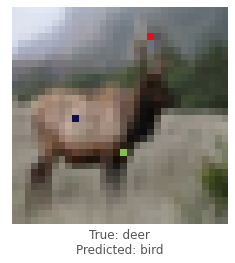


 resnet - image 688 - 57 / 100


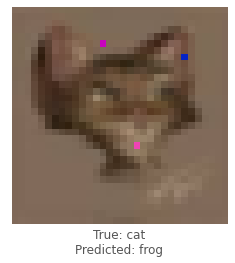


 resnet - image 614 - 58 / 100


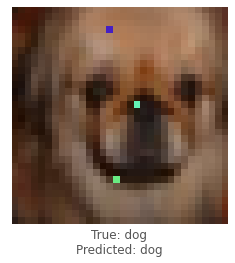


 resnet - image 3084 - 59 / 100


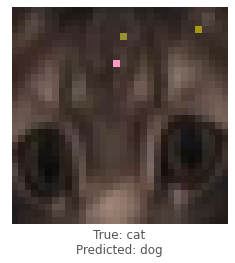


 resnet - image 5392 - 60 / 100


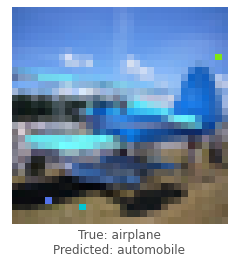


 resnet - image 1859 - 61 / 100


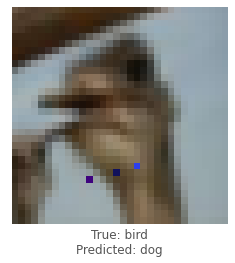


 resnet - image 8183 - 62 / 100


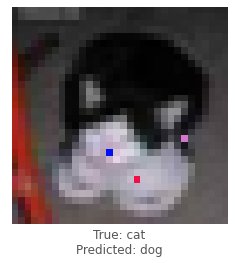


 resnet - image 5303 - 63 / 100


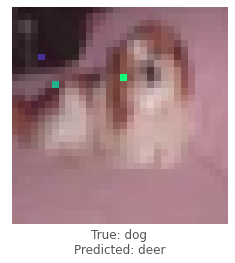


 resnet - image 443 - 64 / 100


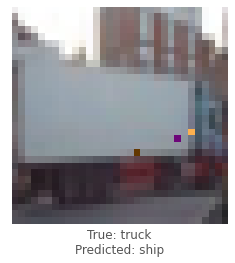


 resnet - image 7604 - 65 / 100


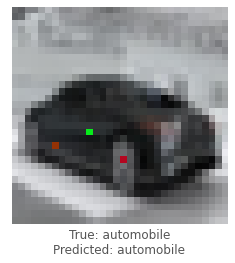


 resnet - image 7307 - 66 / 100


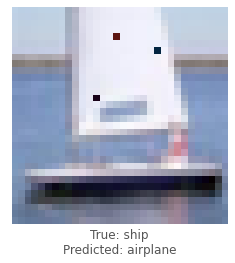


 resnet - image 5586 - 67 / 100


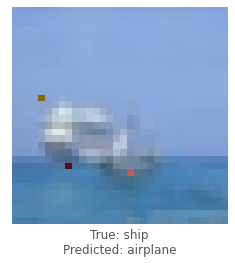


 resnet - image 1483 - 68 / 100


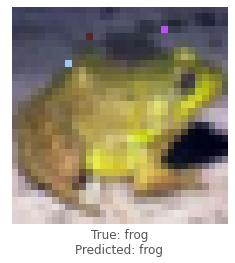


 resnet - image 5512 - 69 / 100


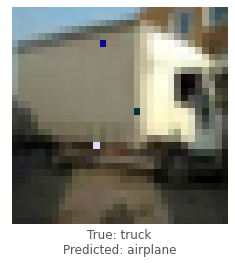


 resnet - image 967 - 70 / 100


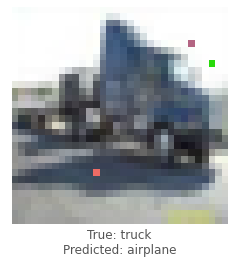


 resnet - image 5738 - 71 / 100


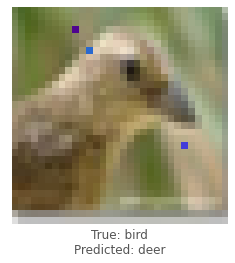


 resnet - image 3213 - 72 / 100


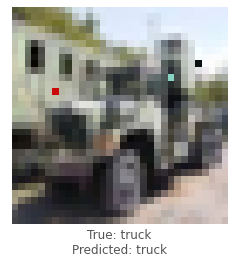


 resnet - image 6683 - 73 / 100


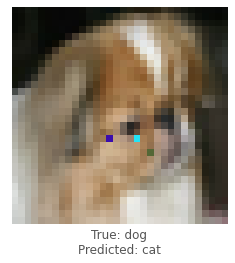


 resnet - image 4074 - 74 / 100


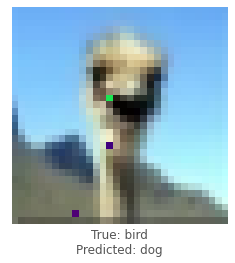


 resnet - image 8820 - 75 / 100


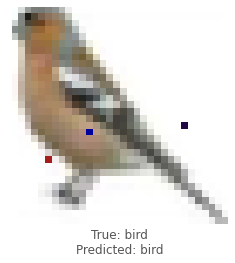


 resnet - image 4028 - 76 / 100


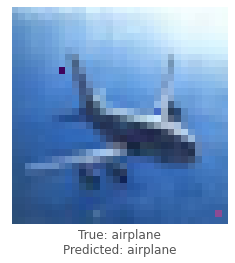


 resnet - image 7390 - 77 / 100


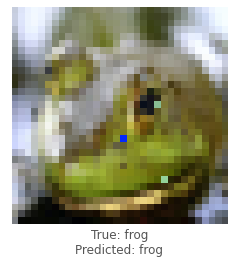


 resnet - image 4584 - 78 / 100


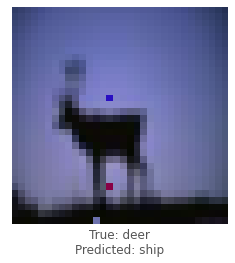


 resnet - image 8111 - 79 / 100


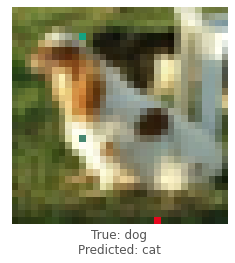


 resnet - image 4274 - 80 / 100


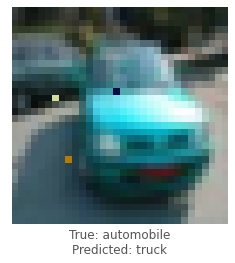


 resnet - image 7191 - 81 / 100


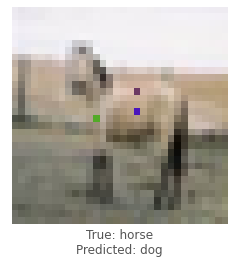


 resnet - image 1650 - 82 / 100


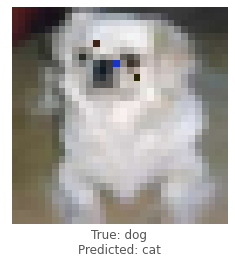


 resnet - image 9189 - 83 / 100


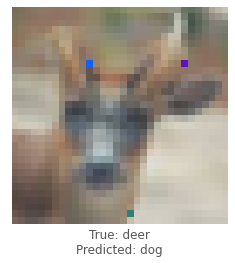


 resnet - image 5959 - 84 / 100


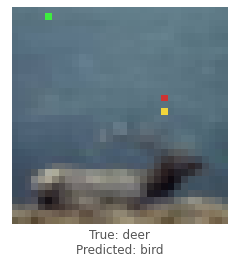


 resnet - image 7084 - 85 / 100


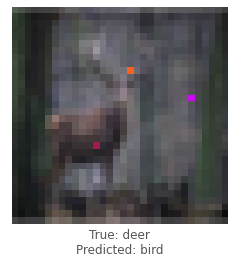


 resnet - image 917 - 86 / 100


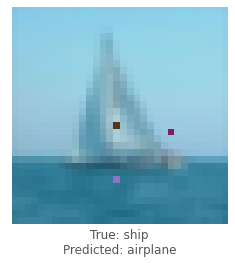


 resnet - image 2030 - 87 / 100


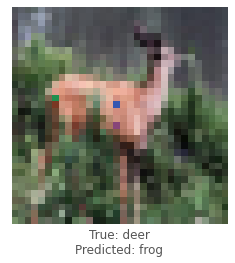


 resnet - image 7062 - 88 / 100


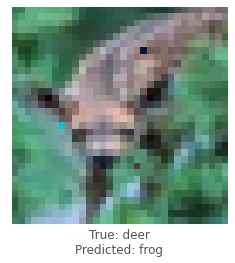


 resnet - image 7770 - 89 / 100


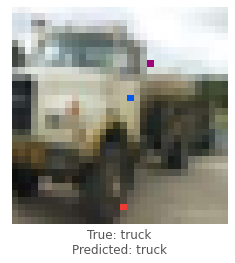


 resnet - image 8670 - 90 / 100


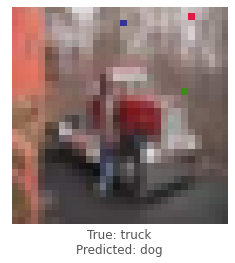


 resnet - image 1503 - 91 / 100


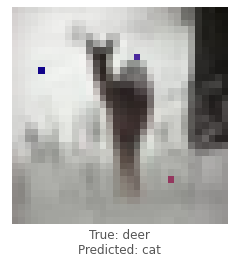


 resnet - image 2887 - 92 / 100


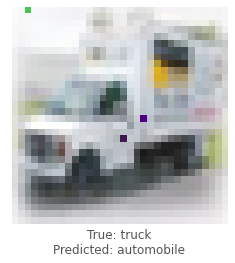


 resnet - image 9547 - 93 / 100


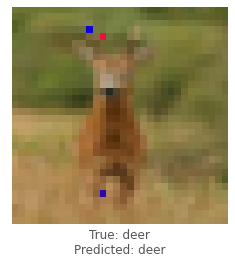


 resnet - image 6167 - 94 / 100


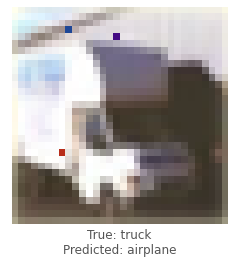


 resnet - image 3541 - 95 / 100


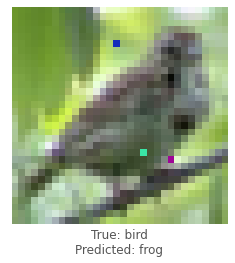


 resnet - image 333 - 96 / 100


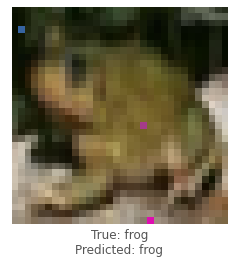


 resnet - image 3046 - 97 / 100


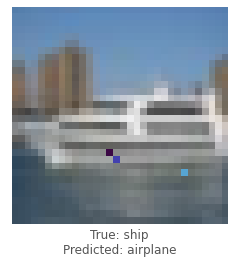


 resnet - image 9125 - 98 / 100


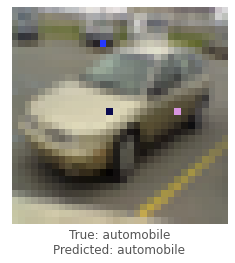


 resnet - image 4913 - 99 / 100


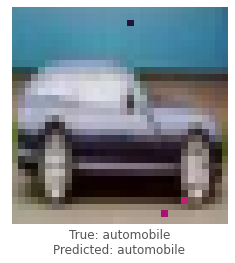


 resnet - image 2717 - 100 / 100


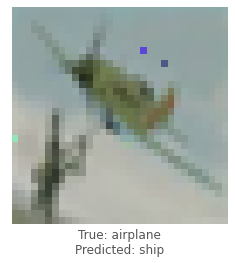


 resnet - image 7022 - 1 / 100


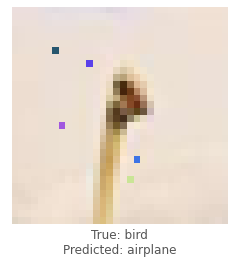


 resnet - image 4137 - 2 / 100


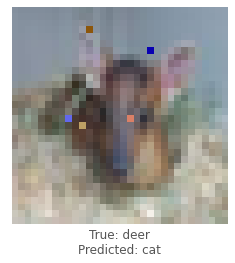


 resnet - image 6757 - 3 / 100


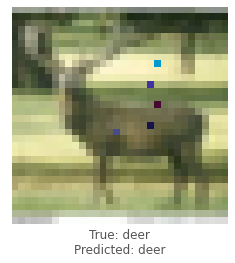


 resnet - image 3024 - 4 / 100


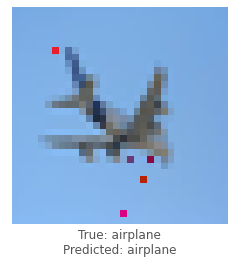


 resnet - image 7069 - 5 / 100


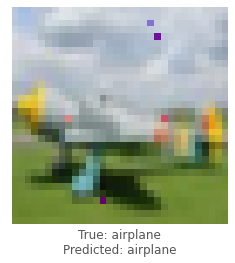


 resnet - image 1527 - 6 / 100


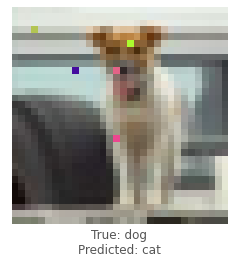


 resnet - image 411 - 7 / 100


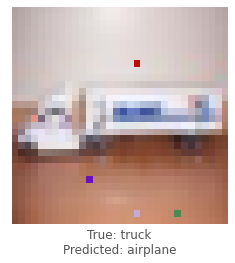


 resnet - image 9251 - 8 / 100


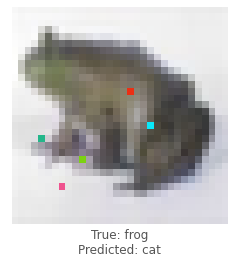


 resnet - image 7672 - 9 / 100


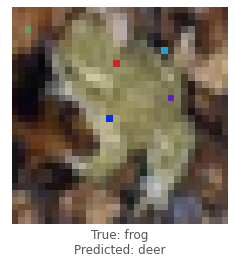


 resnet - image 3000 - 10 / 100


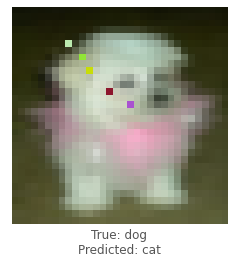


 resnet - image 16 - 11 / 100


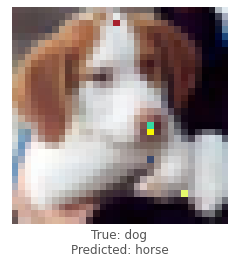


 resnet - image 9974 - 12 / 100


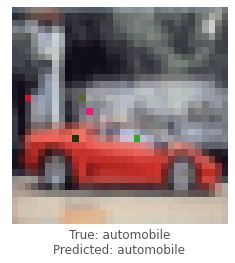


 resnet - image 3693 - 13 / 100


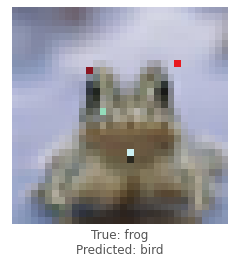


 resnet - image 2975 - 14 / 100


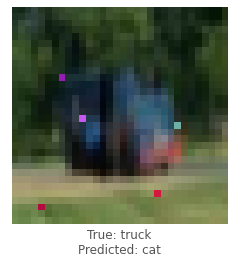


 resnet - image 6907 - 15 / 100


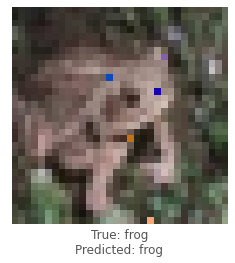


 resnet - image 2997 - 16 / 100


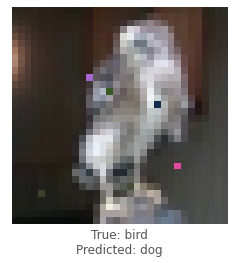


 resnet - image 3419 - 17 / 100


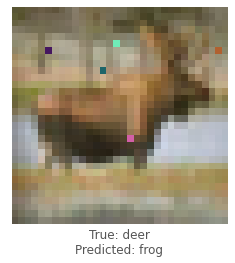


 resnet - image 7441 - 18 / 100


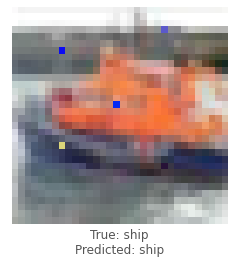


 resnet - image 5389 - 19 / 100


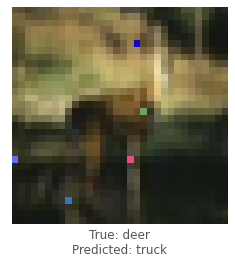


 resnet - image 5479 - 20 / 100


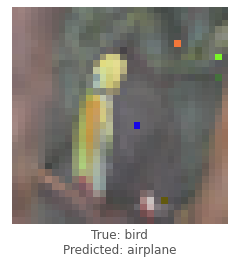


 resnet - image 994 - 21 / 100


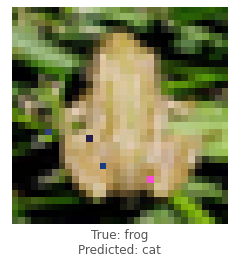


 resnet - image 9232 - 22 / 100


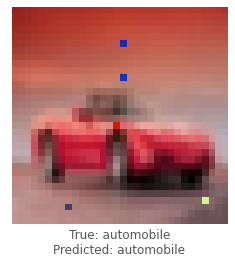


 resnet - image 876 - 23 / 100


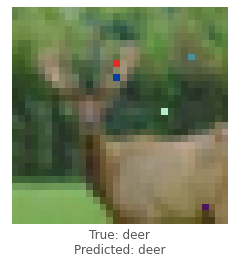


 resnet - image 7964 - 24 / 100


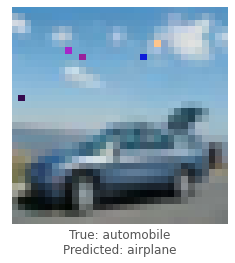


 resnet - image 3425 - 25 / 100


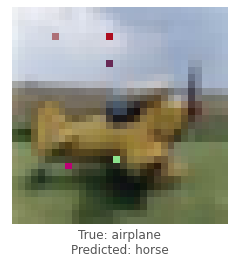


 resnet - image 3841 - 26 / 100


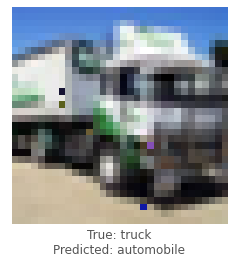


 resnet - image 9293 - 27 / 100


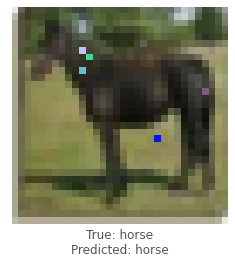


 resnet - image 7158 - 28 / 100


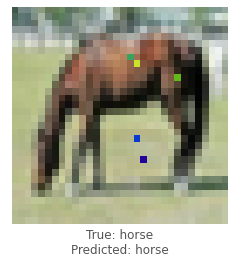


 resnet - image 1670 - 29 / 100


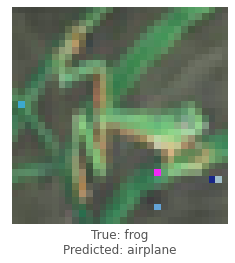


 resnet - image 9921 - 30 / 100


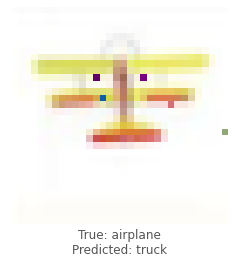


 resnet - image 8539 - 31 / 100


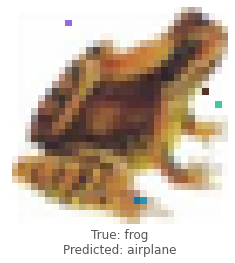


 resnet - image 8423 - 32 / 100


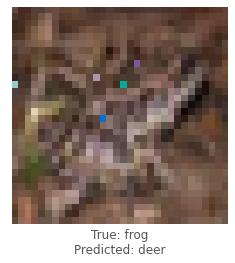


 resnet - image 3703 - 33 / 100


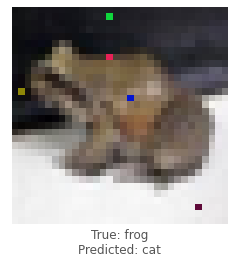


 resnet - image 8620 - 34 / 100


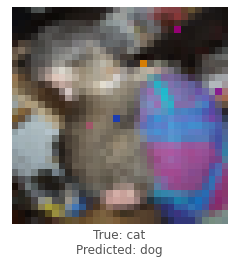


 resnet - image 8448 - 35 / 100


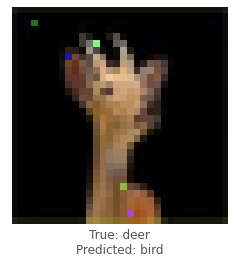


 resnet - image 4185 - 36 / 100


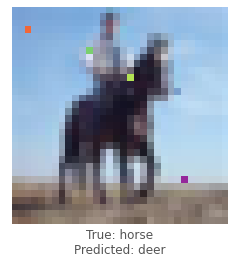


 resnet - image 2416 - 37 / 100


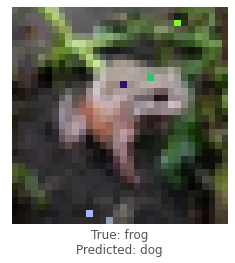


 resnet - image 6639 - 38 / 100


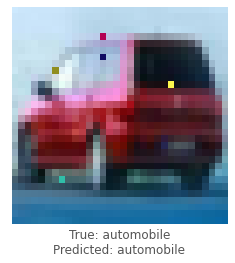


 resnet - image 1603 - 39 / 100


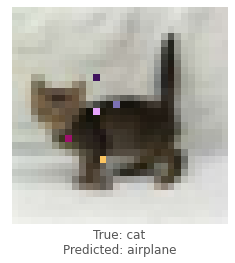


 resnet - image 6274 - 40 / 100


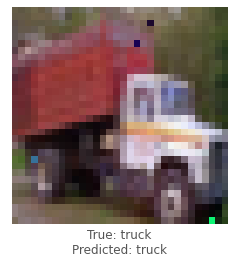


 resnet - image 1881 - 41 / 100


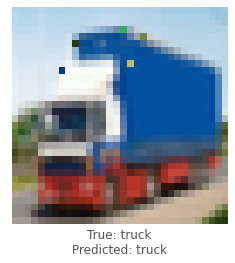


 resnet - image 6156 - 42 / 100


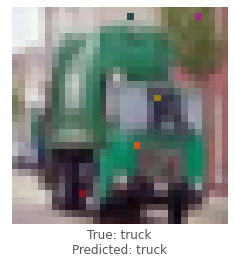


 resnet - image 3238 - 43 / 100


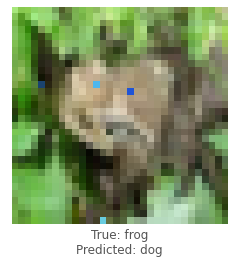


 resnet - image 606 - 44 / 100


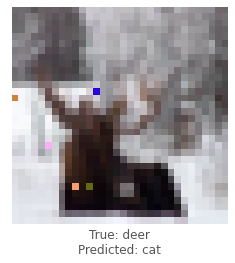


 resnet - image 5717 - 45 / 100


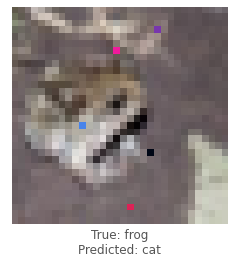


 resnet - image 988 - 46 / 100


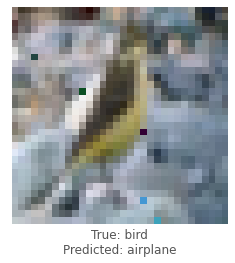


 resnet - image 990 - 47 / 100


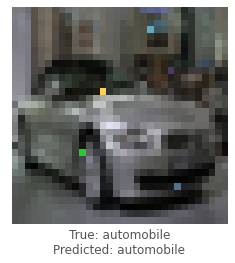


 resnet - image 9700 - 48 / 100


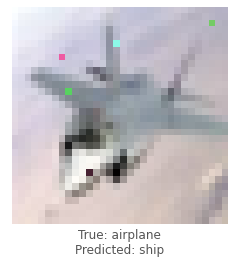


 resnet - image 2009 - 49 / 100


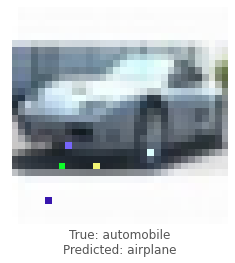


 resnet - image 9745 - 50 / 100


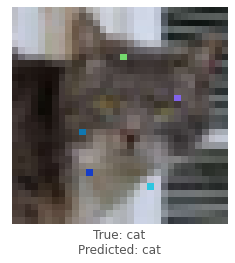


 resnet - image 26 - 51 / 100


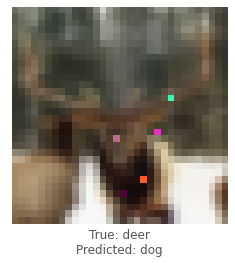


 resnet - image 1133 - 52 / 100


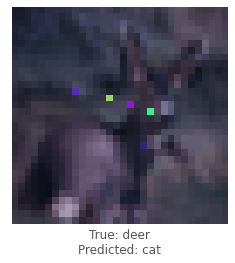


 resnet - image 8137 - 53 / 100


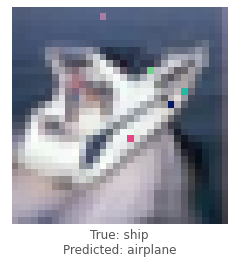


 resnet - image 2642 - 54 / 100


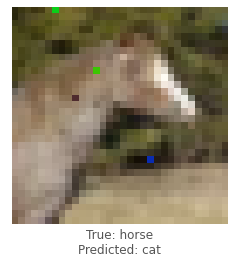


 resnet - image 4203 - 55 / 100


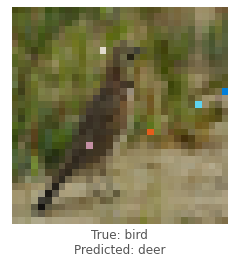


 resnet - image 7957 - 56 / 100


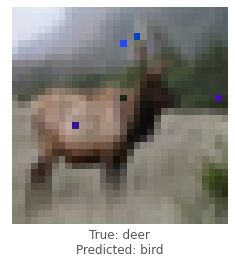


 resnet - image 688 - 57 / 100


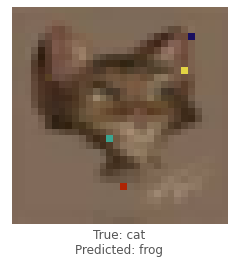


 resnet - image 614 - 58 / 100


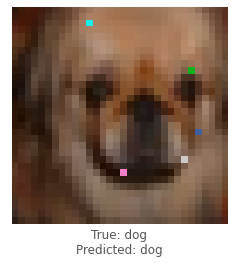


 resnet - image 3084 - 59 / 100


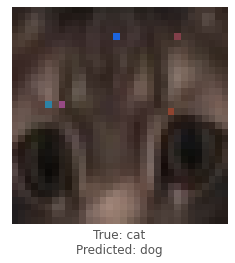


 resnet - image 5392 - 60 / 100


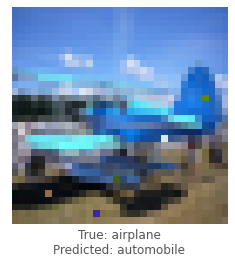


 resnet - image 1859 - 61 / 100


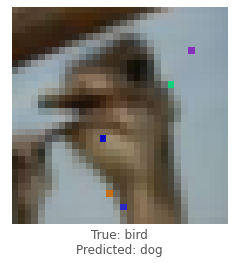


 resnet - image 8183 - 62 / 100


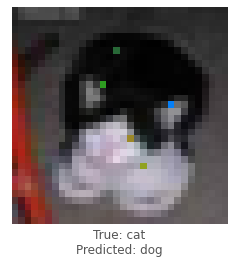


 resnet - image 5303 - 63 / 100


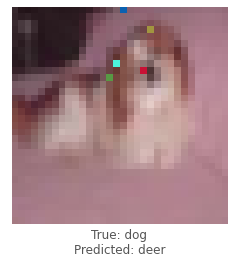


 resnet - image 443 - 64 / 100


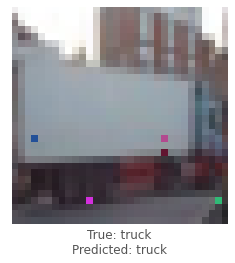


 resnet - image 7604 - 65 / 100


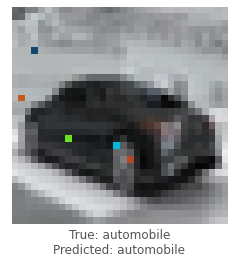


 resnet - image 7307 - 66 / 100


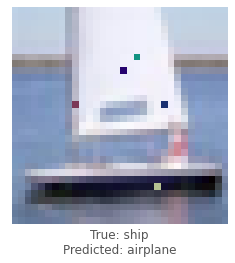


 resnet - image 5586 - 67 / 100


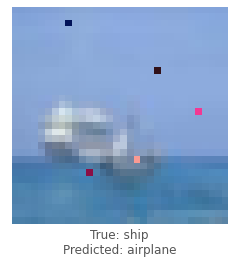


 resnet - image 1483 - 68 / 100


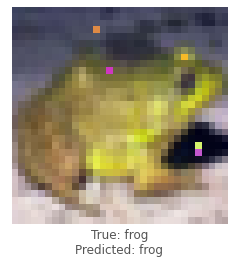


 resnet - image 5512 - 69 / 100


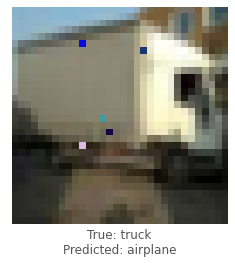


 resnet - image 967 - 70 / 100


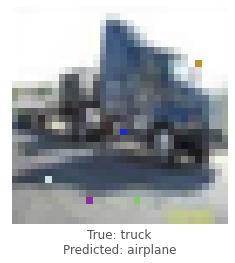


 resnet - image 5738 - 71 / 100


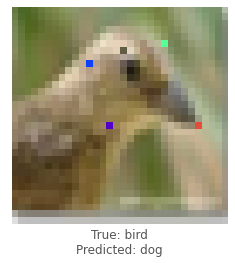


 resnet - image 3213 - 72 / 100


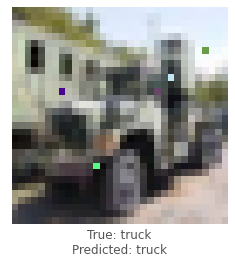


 resnet - image 6683 - 73 / 100


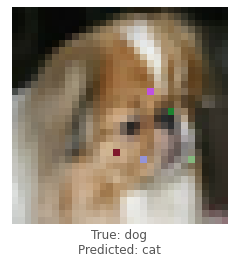


 resnet - image 4074 - 74 / 100


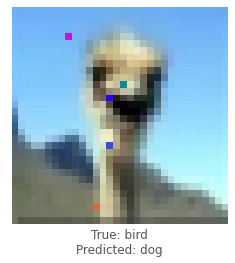


 resnet - image 8820 - 75 / 100


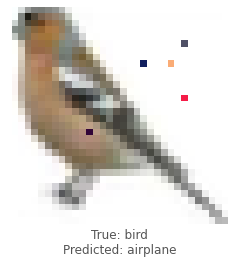


 resnet - image 4028 - 76 / 100


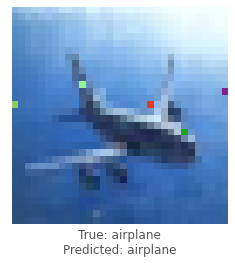


 resnet - image 7390 - 77 / 100


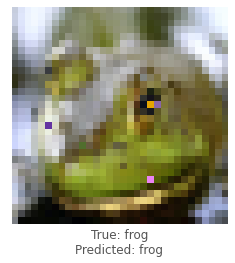


 resnet - image 4584 - 78 / 100


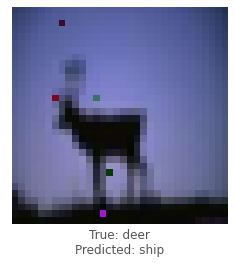


 resnet - image 8111 - 79 / 100


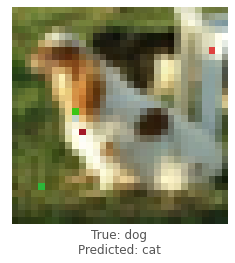


 resnet - image 4274 - 80 / 100


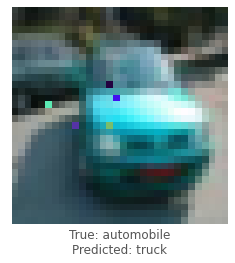


 resnet - image 7191 - 81 / 100


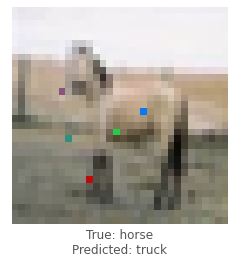


 resnet - image 1650 - 82 / 100


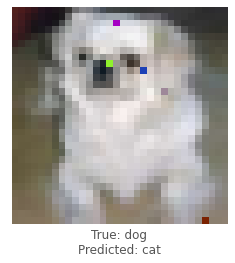


 resnet - image 9189 - 83 / 100


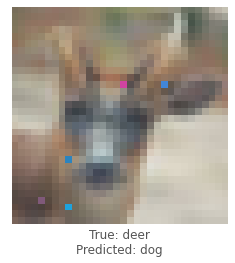


 resnet - image 5959 - 84 / 100


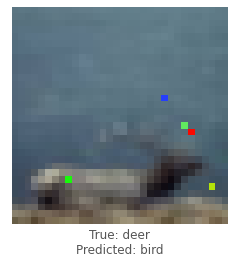


 resnet - image 7084 - 85 / 100


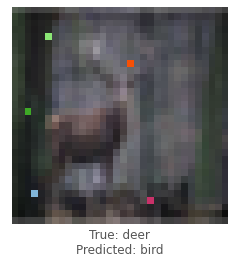


 resnet - image 917 - 86 / 100


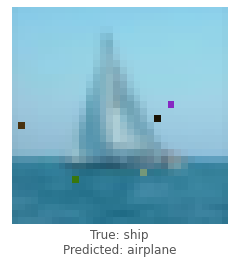


 resnet - image 2030 - 87 / 100


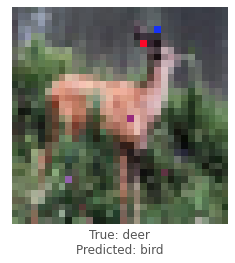


 resnet - image 7062 - 88 / 100


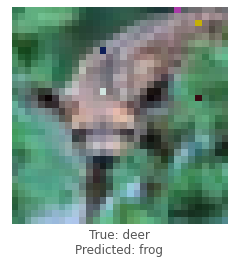


 resnet - image 7770 - 89 / 100


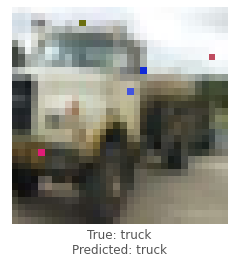


 resnet - image 8670 - 90 / 100


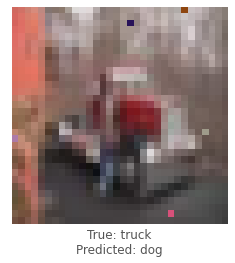


 resnet - image 1503 - 91 / 100


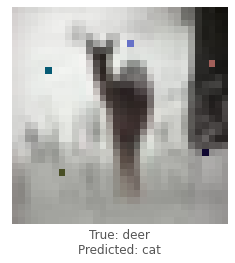


 resnet - image 2887 - 92 / 100


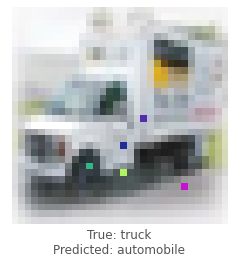


 resnet - image 9547 - 93 / 100


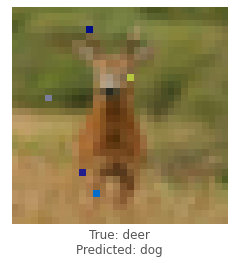


 resnet - image 6167 - 94 / 100


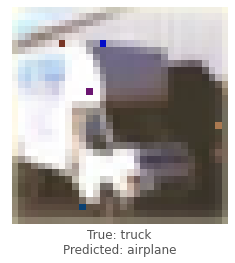


 resnet - image 3541 - 95 / 100


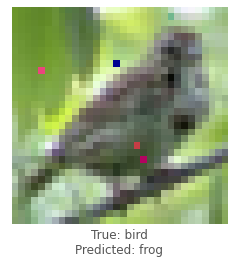


 resnet - image 333 - 96 / 100


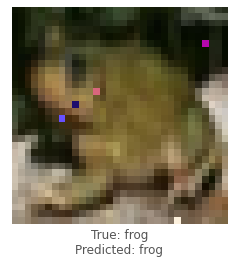


 resnet - image 3046 - 97 / 100


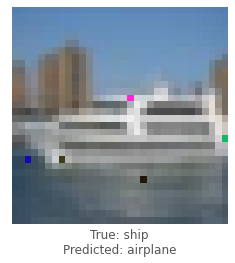


 resnet - image 9125 - 98 / 100


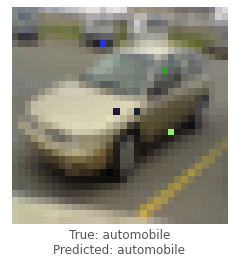


 resnet - image 4913 - 99 / 100


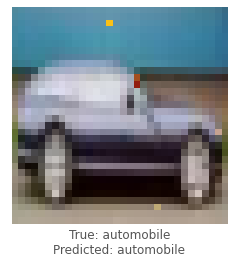


 resnet - image 2717 - 100 / 100


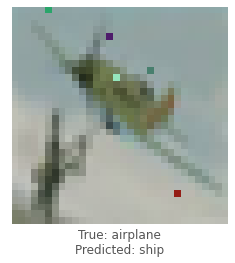

In [46]:
untargeted = attack_all(models, samples=100, targeted=False)


 lenet - image 7897 - 1 / 10
Attacking with target airplane


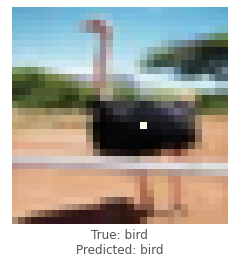

Attacking with target automobile


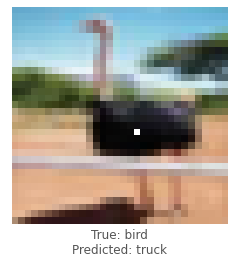

Attacking with target bird
Attacking with target cat


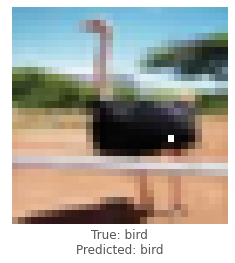

Attacking with target deer


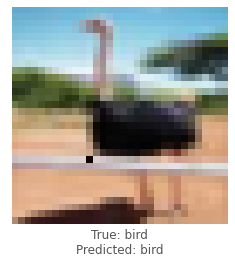

Attacking with target dog


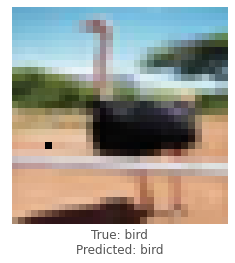

Attacking with target frog


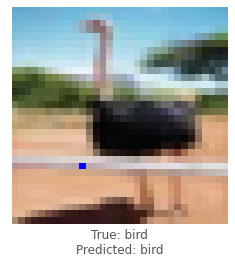

Attacking with target horse


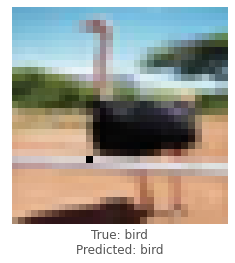

Attacking with target ship


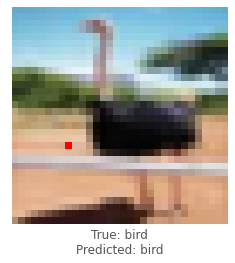

Attacking with target truck


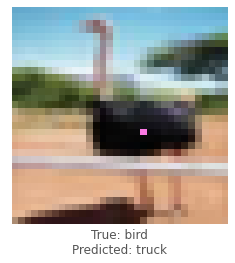


 lenet - image 7063 - 2 / 10
Attacking with target airplane


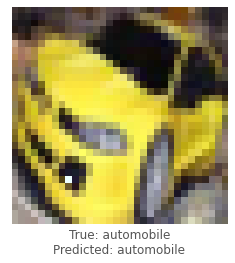

Attacking with target automobile
Attacking with target bird


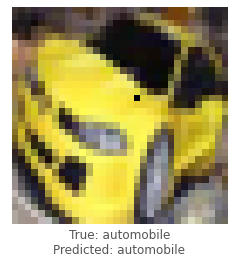

Attacking with target cat


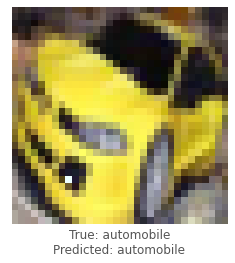

Attacking with target deer


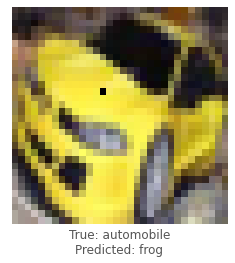

Attacking with target dog


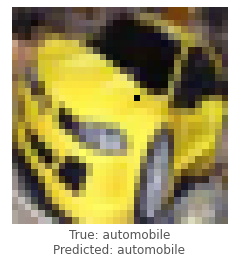

Attacking with target frog


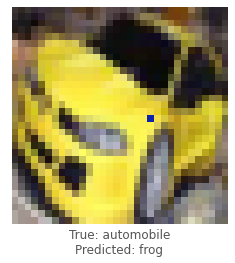

Attacking with target horse


/content/differential_evolution.py:585: RuntimeWarning: divide by zero encountered in double_scalars
  convergence=self.tol / convergence) is True):


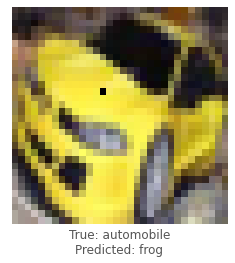

Attacking with target ship


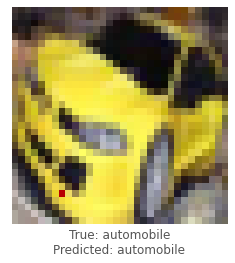

Attacking with target truck


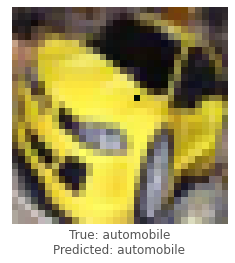


 lenet - image 1252 - 3 / 10
Attacking with target airplane


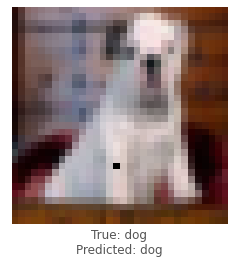

Attacking with target automobile


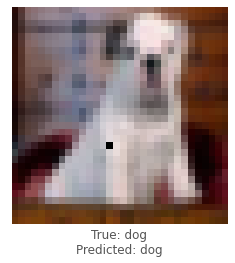

Attacking with target bird


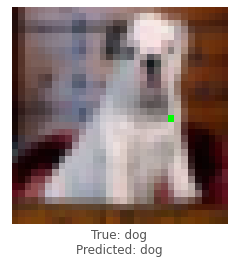

Attacking with target cat


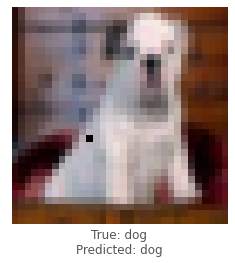

Attacking with target deer


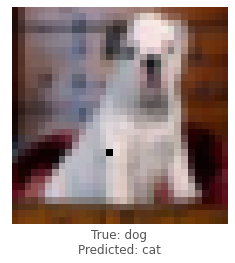

Attacking with target dog
Attacking with target frog


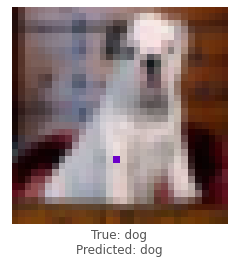

Attacking with target horse


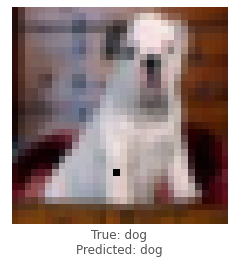

Attacking with target ship


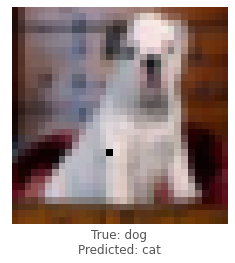

Attacking with target truck


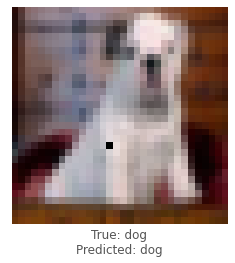


 lenet - image 4641 - 4 / 10
Attacking with target airplane


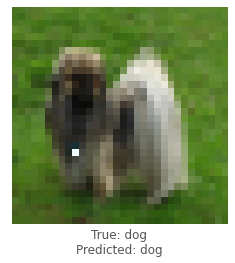

Attacking with target automobile


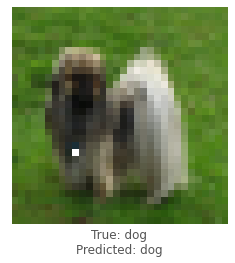

Attacking with target bird


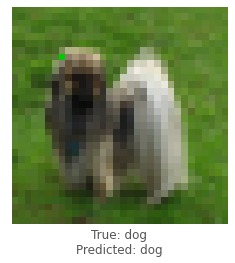

Attacking with target cat


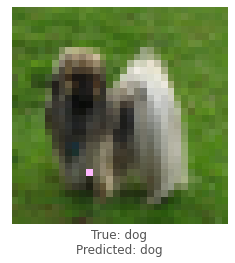

Attacking with target deer


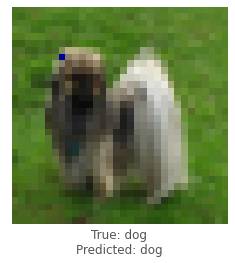

Attacking with target dog
Attacking with target frog


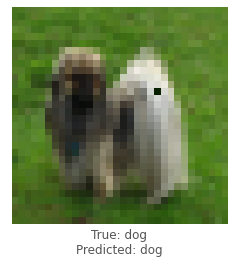

Attacking with target horse


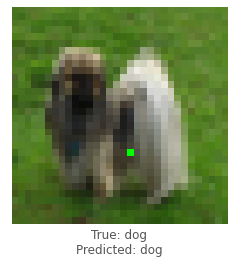

Attacking with target ship


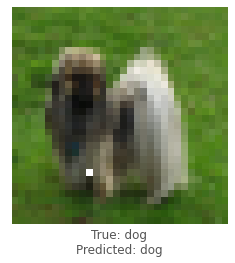

Attacking with target truck


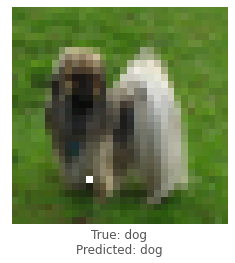


 lenet - image 2983 - 5 / 10
Attacking with target airplane


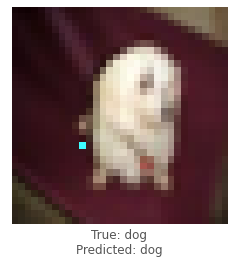

Attacking with target automobile


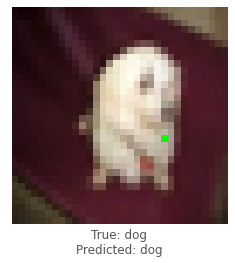

Attacking with target bird


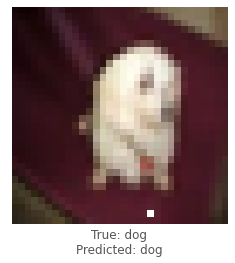

Attacking with target cat


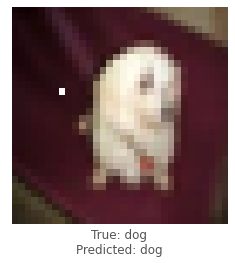

Attacking with target deer


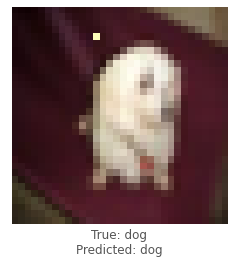

Attacking with target dog
Attacking with target frog


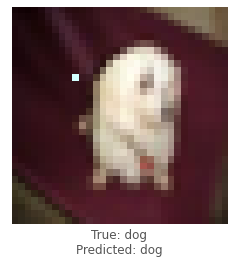

Attacking with target horse


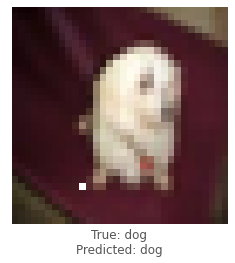

Attacking with target ship


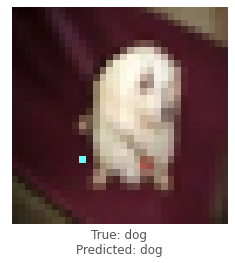

Attacking with target truck


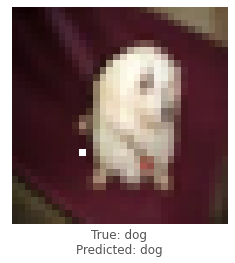


 lenet - image 1877 - 6 / 10
Attacking with target airplane


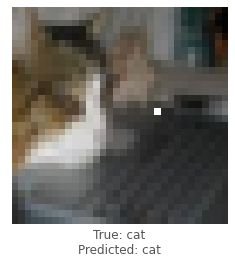

Attacking with target automobile


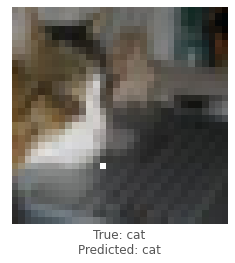

Attacking with target bird


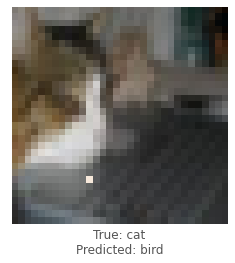

Attacking with target cat
Attacking with target deer


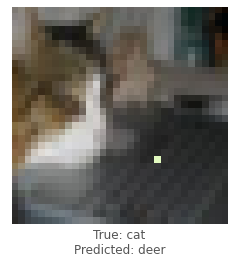

Attacking with target dog


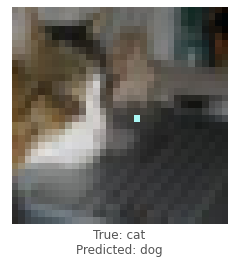

Attacking with target frog


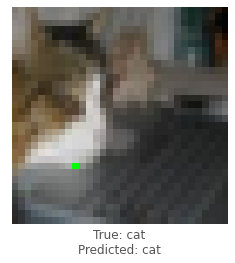

Attacking with target horse


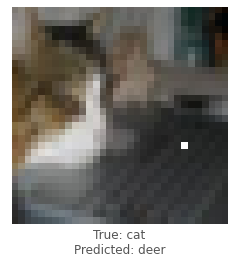

Attacking with target ship


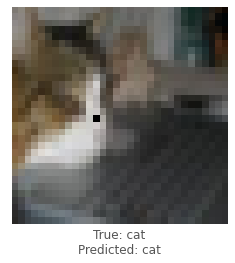

Attacking with target truck


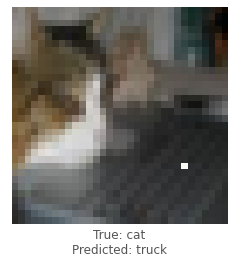


 lenet - image 2567 - 7 / 10
Attacking with target airplane


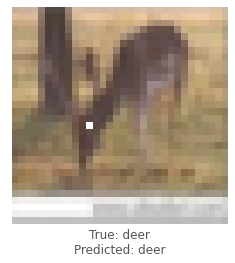

Attacking with target automobile


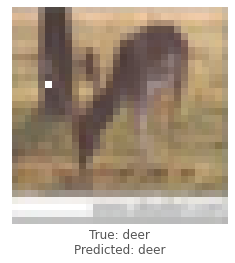

Attacking with target bird


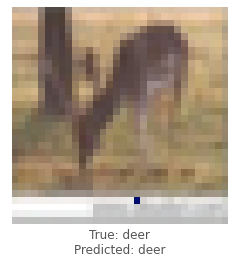

Attacking with target cat


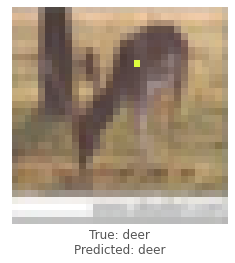

Attacking with target deer
Attacking with target dog


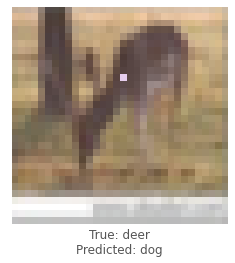

Attacking with target frog


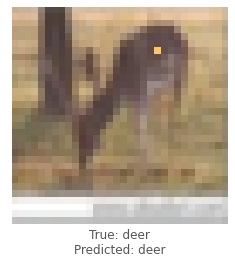

Attacking with target horse


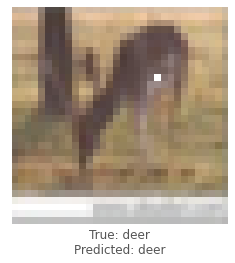

Attacking with target ship


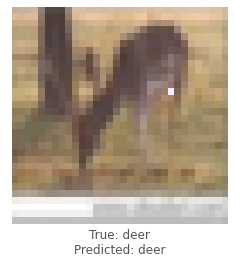

Attacking with target truck


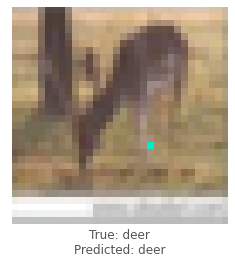


 lenet - image 1241 - 8 / 10
Attacking with target airplane
Attacking with target automobile


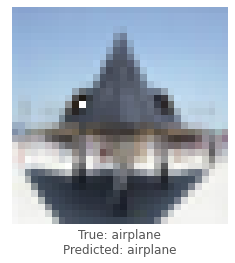

Attacking with target bird


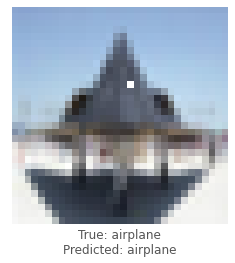

Attacking with target cat


In [ ]:
targeted = attack_all(models, samples=10, targeted=True)

### Attack Statistics

Print the final results! 

In [ ]:
# Load the results
untargeted, targeted = helper.load_results()

In [ ]:
columns = ['model', 'pixels', 'image', 'true', 'predicted', 'success', 'cdiff', 'prior_probs', 'predicted_probs', 'perturbation']
untargeted_results = pd.DataFrame(untargeted, columns=columns)
targeted_results = pd.DataFrame(targeted, columns=columns)

#### Untargeted

In [ ]:
helper.attack_stats(untargeted_results, models, network_stats)

#### Targeted

In [ ]:
helper.attack_stats(targeted_results, models, network_stats)

### Show some successful attacks

Plot 9 random successful attack images

In [ ]:
print('Untargeted Attack')
helper.visualize_attack(untargeted_results, class_names)

In [ ]:
print('Targeted Attack')
helper.visualize_attack(targeted_results, class_names)

## Conclusions

It appears that the accuracy of a model is not strongly correlated with the chance of performing a successful attack on an image. Perhaps surprisingly, the purely convolutional model is the most resistant CNN to these types of attacks. In addition, the capsule network CapsNet has the lowest attack success rate out of all the models, although it is still vulnerable to attack.

[Part 2](1_one-pixel-attack-cifar10.ipynb)

## Credits
 -  This implemenation is based off of the original paper describing the one pixel attack: https://arxiv.org/abs/1710.08864
 - Base code for iPython notebook: https://github.com/09rohanchopra/cifar10
 - Keras Cifar10 models: https://github.com/BIGBALLON/cifar-10-cnn
 - Scipy's differential evolution implementation: https://docs.scipy.org/doc/scipy-0.17.0/reference/generated/scipy.optimize.differential_evolution.html
 - State of the art: https://github.com/RedditSota/state-of-the-art-result-for-machine-learning-problems
 - CapsNet Keras: https://github.com/XifengGuo/CapsNet-Keras
 - CapsNet with Cifar: https://github.com/theblackcat102/dynamic-routing-capsule-cifar